# <font color='purple'> **Práctica 4. Sensando y análisis fisiológico.** </font>

**Elaborado por:** Scarlett Magdaleno Gatica. 

En esta práctica se propone recopilar datos fisiológicos de estudiantes durante la exposición de su anteproyecto ante dos profesores que realizan preguntas. El objetivo principal en este Notebook es desarrollar un clasificador que distinga entre los diferentes contextos de la exposición:

+ **Exponiendo:** Cuando el participante presenta su trabajo.
+ **Escuchando a los profesores:** Cuando el participante atiende las preguntas o comentarios de los profesores.
+ **Respondiendo a los profesores:** Cuando el participante interviene para responder a las preguntas o comentarios de los profesores.

La información recopilada permitirá analizar la respuesta fisiológica del estudiante en cada contexto y desarrollar un modelo que pueda identificar automáticamente el contexto actual de la exposición.

### <font color='purple'> **Dataset** </font>

El conjunto de datos se generó mediante la captura de la variabilidad de la frecuencia cardíaca (HRV) de los participantes durante la exposición de su anteproyecto. La HRV se midió con un sensor colocado en el esternón, que capturó las señales eléctricas del corazón.

La anotación del conjunto de datos se realizó mediante la visualización del video de las exposiciones. Se identificaron manualmente los diferentes contextos de la exposición (exponiendo, escuchando a los profesores y respondiendo a los profesores) y se etiquetó cada segmento del video en consecuencia.

**Notas importantes:**
- El archivo `etiquetado.csv` utilizado para segmentar por repeticiones se encuentra en este repositorio.

### <font color='purple'> **Importamos las librerías** </font>

In [1]:
# system libraries
import os
import sys
import re

# data 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# files
from scipy.io.wavfile import write
import shutil

# data segmentation
import datetime

# feature extraction
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# feature selection
from sklearn.feature_selection import mutual_info_classif

# data partitioning
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# model construction
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.validation import check_array
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## <font color='purple'> **1.- Análisis Exploratorio** </font>

Se realizará un análisis exploratorio de las señales de variabilidad de la frecuencia cardíaca (HRV) recolectadas durante la exposición de los participantes. La HRV se mide como la variación en los intervalos entre latidos cardíacos y se expresa en milisegundos. Para visualizar una gráfica de HRV en función del tiempo, se calculará la suma de prefijos de los valores HRV y se convertirán a segundos.

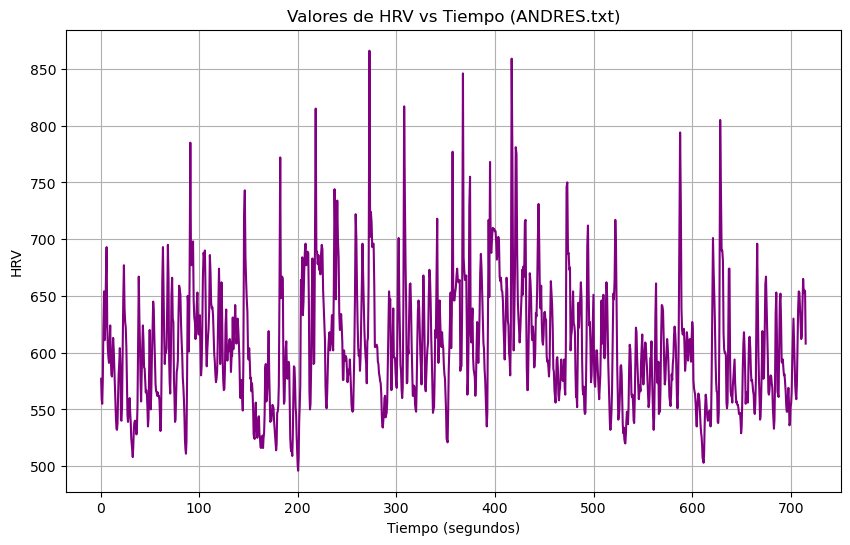

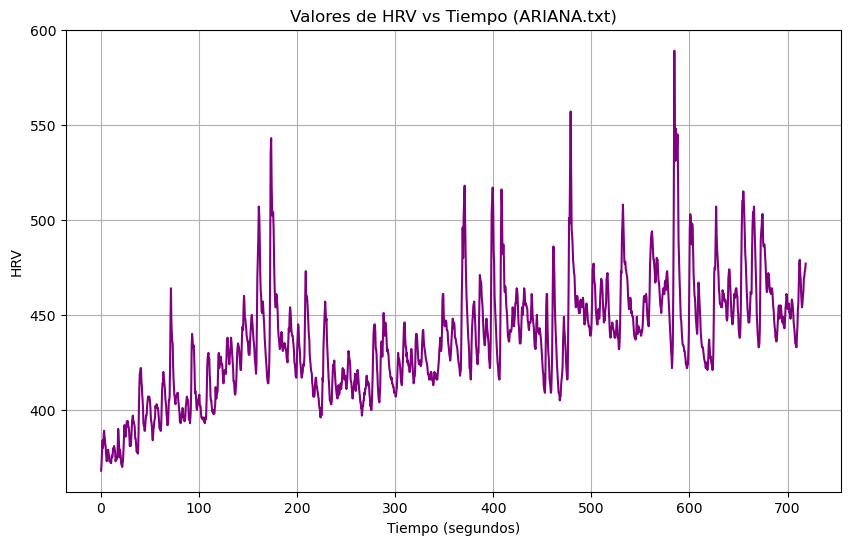

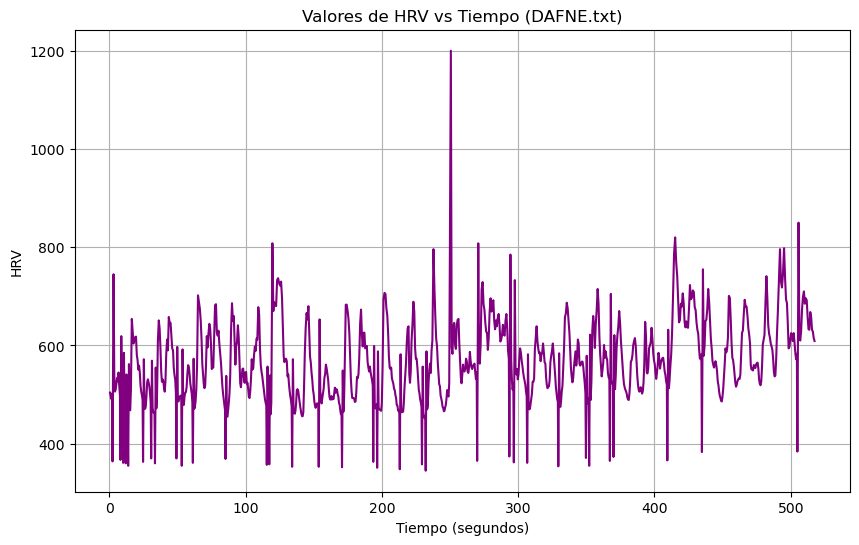

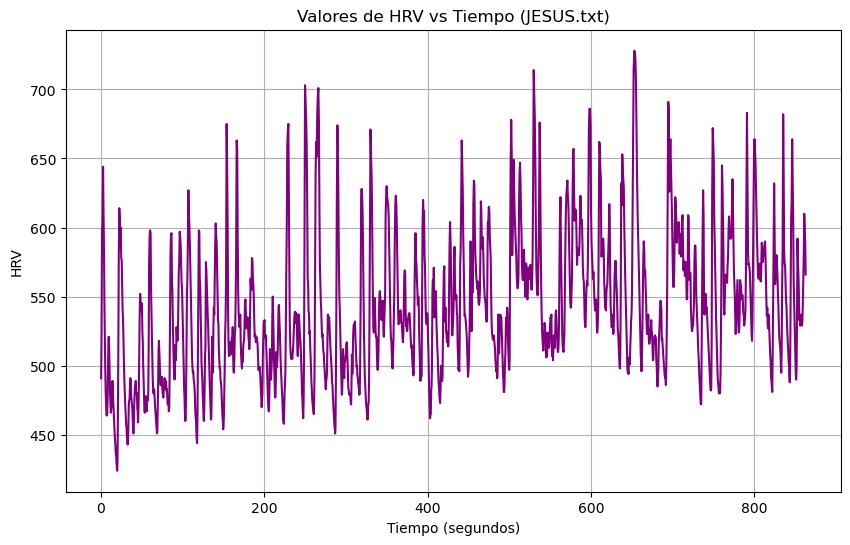

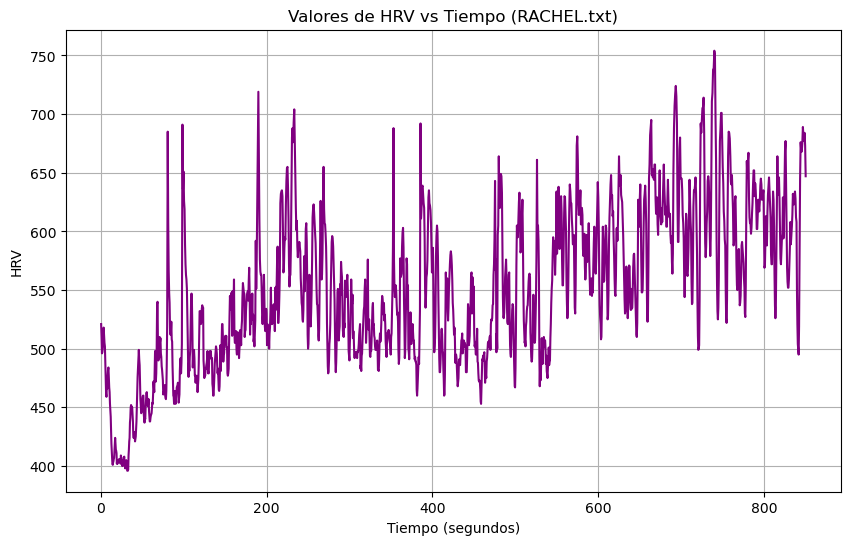

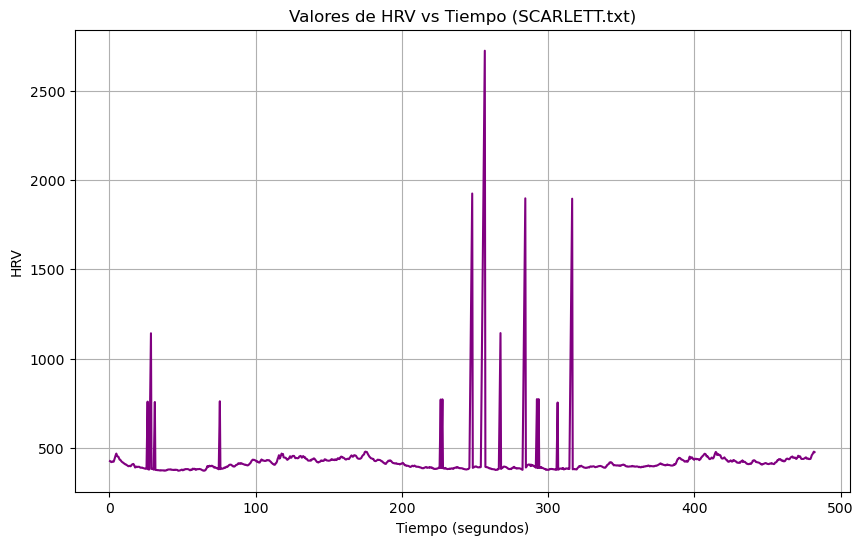

In [2]:
def cargar_datos_desde_archivo(archivo):
    with open(archivo, 'r') as f:
        datos = [float(linea.strip()) for linea in f]
    return datos

def tiempo_a_segundos(tiempo_str):
    tiempo = datetime.datetime.strptime(tiempo_str, '%M:%S')
    return tiempo.minute * 60 + tiempo.second

def calcular_tiempos_acumulados(datos_hrv):
    tiempos_acumulados = [0]
    for valor_hrv in datos_hrv:
        tiempo_segundos = valor_hrv / 1000  # Convertir milisegundos a segundos
        tiempo_acumulado = tiempos_acumulados[-1] + tiempo_segundos
        tiempos_acumulados.append(tiempo_acumulado)
    return tiempos_acumulados[1:]  # Eliminar el primer elemento que es cero

def visualizar_hrv_vs_tiempo(archivo):
    nombre_archivo = os.path.basename(archivo)
    datos_hrv = cargar_datos_desde_archivo(archivo)
    tiempos_acumulados = calcular_tiempos_acumulados(datos_hrv)
    
    plt.figure(figsize=(10, 6))
    plt.plot(tiempos_acumulados, datos_hrv, color='purple', linestyle='-')
    plt.title(f'Valores de HRV vs Tiempo ({nombre_archivo})')
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('HRV')
    plt.grid(True)
    plt.show()

carpeta_hrv = 'HRV'
archivos_txt = [archivo for archivo in os.listdir(carpeta_hrv) if archivo.lower().endswith('.txt')]

for archivo in archivos_txt:
    visualizar_hrv_vs_tiempo(os.path.join(carpeta_hrv, archivo))

**Observaciones:** 

Patrones:

+ Ariana, Jesús y Rachel: El intervalo entre latidos aumenta a lo largo de la exposición, lo que podría indicar una disminución en el nerviosismo o un aumento en la tranquilidad.
+ Andrés, Dafne y Scarlett: Mantienen los intervalos entre latidos dentro de rangos definidos.

Valores atípicos:

+ Dafne y Scarlett: Presentan picos superiores a 1200 milisegundos.

Rango general:

+ La mayoría de los intervalos se encuentran entre 200 y 1000 milisegundos.


Para observar mejor el comportamiento de la señal de Scarlett, se ha limita la gráfica a valores entre 0 y 600 milisegundos. Esto permite apreciar con mayor detalle las variaciones en la HRV, ya que los valores atípicos presentes en la gráfica original distorsionan la visualización del comportamiento general.

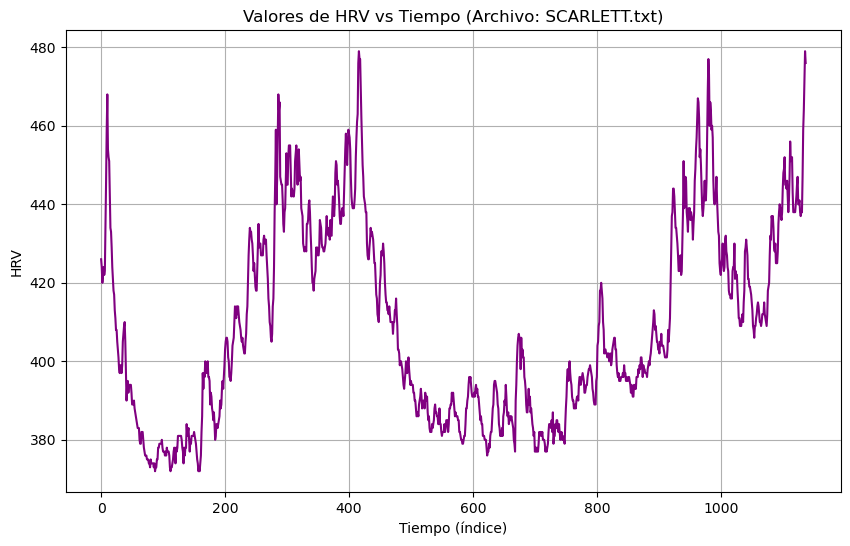

In [3]:
# Archivo a graficar
archivo_a_graficar = 'SCARLETT.txt'
carpeta_hrv = 'HRV'

# Ruta completa del archivo
ruta_archivo = os.path.join(carpeta_hrv, archivo_a_graficar)

# Cargar datos de HRV desde el archivo
datos_hrv = cargar_datos_desde_archivo(ruta_archivo)

# Limitar los datos de HRV al rango de 0 a 1000
datos_hrv_filtrados = [dato for dato in datos_hrv if 0 <= dato <= 600]

plt.figure(figsize=(10, 6))
plt.plot(range(len(datos_hrv_filtrados)), datos_hrv_filtrados, color='purple', linestyle='-')
plt.title(f'Valores de HRV vs Tiempo (Archivo: {archivo_a_graficar})')
plt.xlabel('Tiempo (índice)')
plt.ylabel('HRV')
plt.grid(True)
plt.show()

**Observaciones:** 
+ Si bien la señal de Scarlett se encuentra en un rango de intervalos que corresponde a un ritmo cardíaco rápido, se observan aumentos y disminuciones en determinados momentos de la exposición. Sería interesante identificar qué momentos específicos provocan un mayor ritmo cardíaco como respuesta.

Observemos las gráficas suavizadas para ver si notamos alguna otra tendencia.

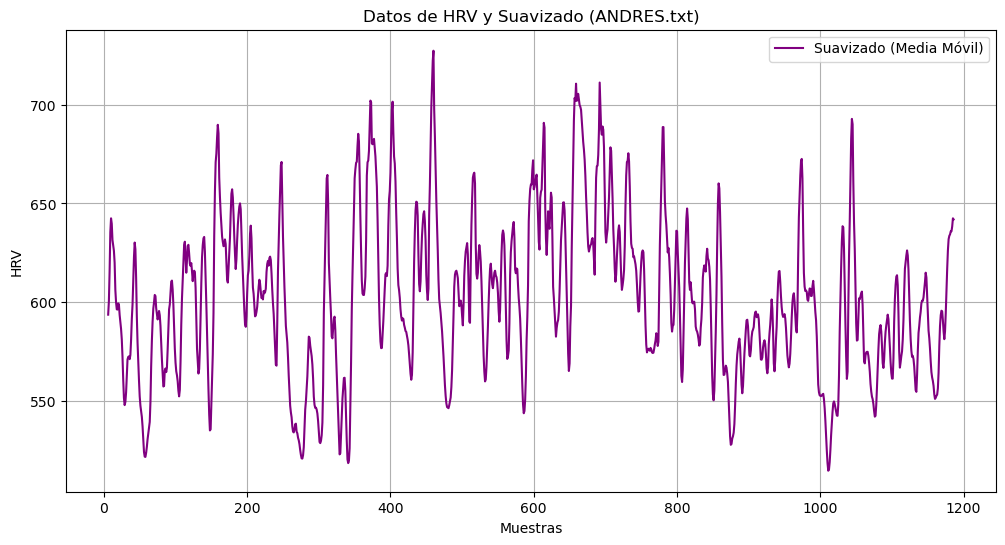

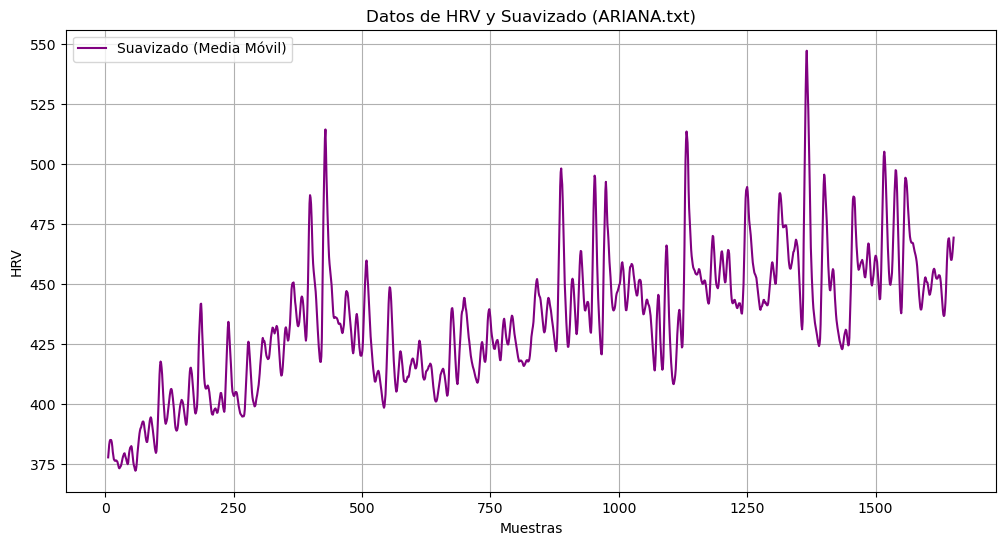

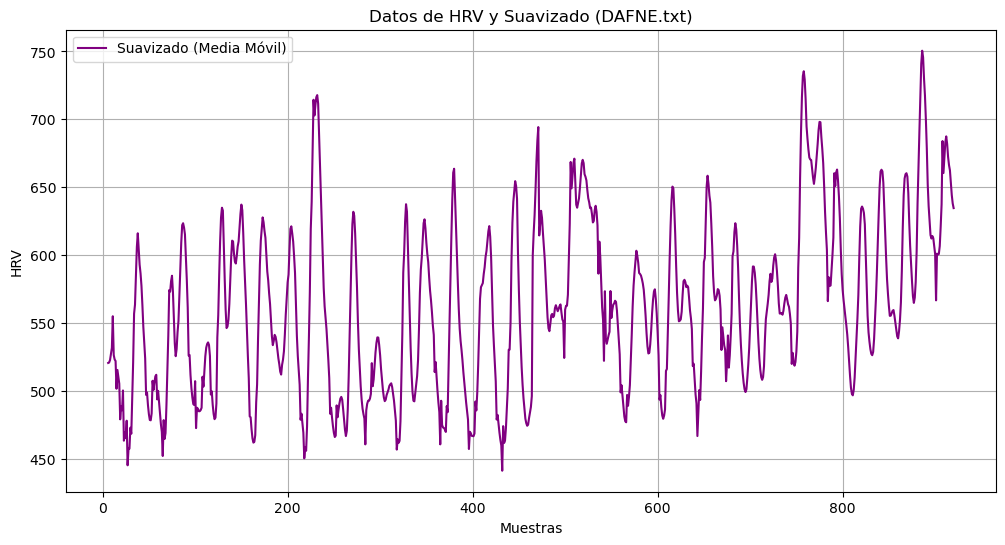

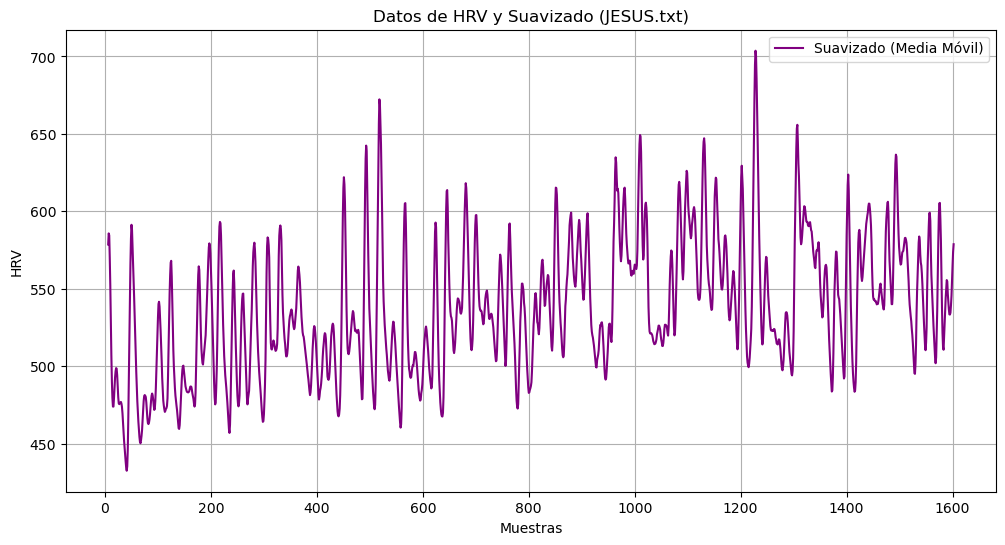

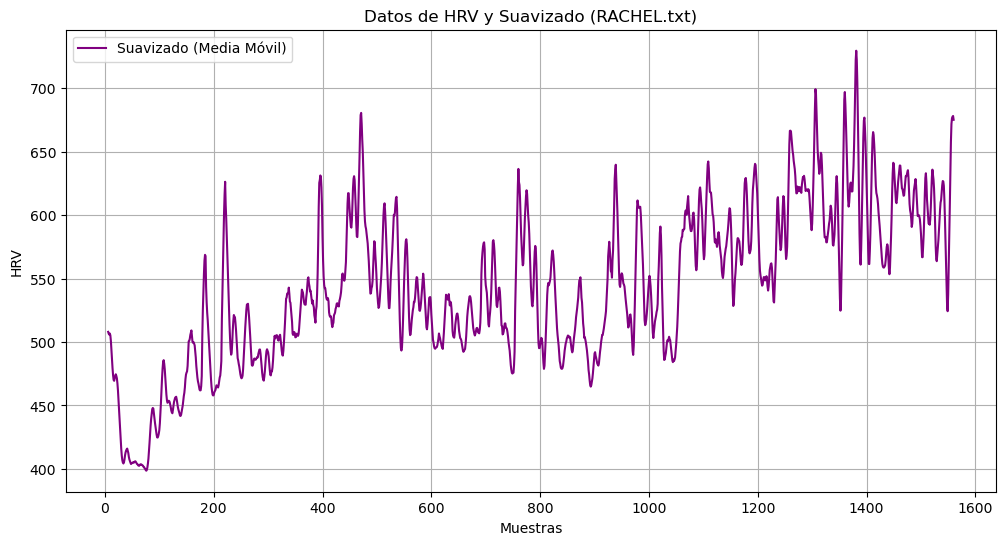

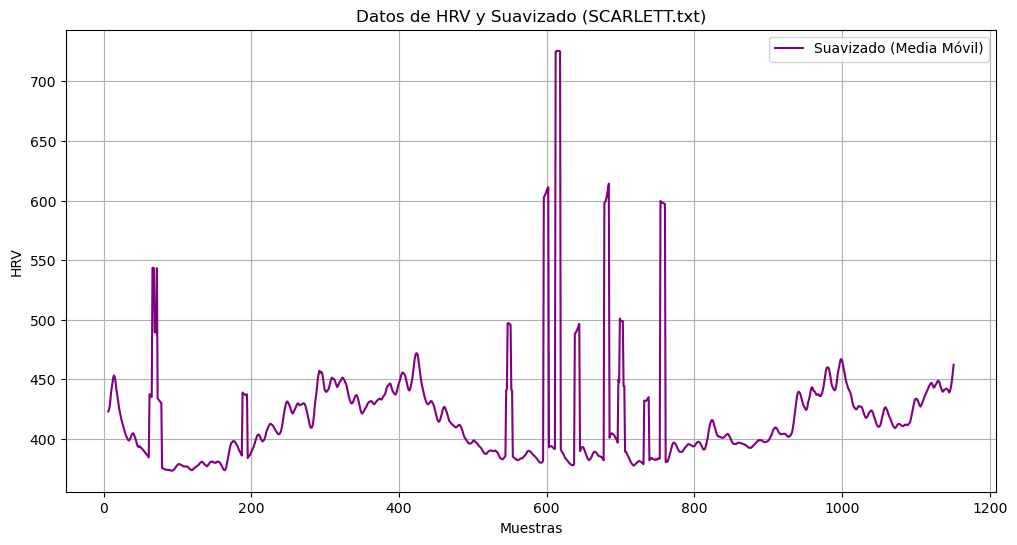

In [4]:
def suavizar_datos(datos, ventana=7):
    return pd.Series(datos).rolling(ventana).mean()


carpeta_hrv = 'HRV'
archivos_txt = [archivo for archivo in os.listdir(carpeta_hrv) if archivo.lower().endswith('.txt')]

for archivo in archivos_txt:
    ruta_archivo = os.path.join(carpeta_hrv, archivo)
    
    # Cargar datos de HRV desde el archivo
    datos_hrv = cargar_datos_desde_archivo(ruta_archivo)
    
    # Suavizar datos
    datos_suavizados = suavizar_datos(datos_hrv)
    
    # Graficar HRV suavizado
    plt.figure(figsize=(12, 6))
    plt.plot(datos_suavizados, color='purple', label='Suavizado (Media Móvil)')
    plt.title(f'Datos de HRV y Suavizado ({archivo})')
    plt.xlabel('Muestras')
    plt.ylabel('HRV')
    plt.legend()
    plt.grid(True)
    plt.show()

**Observaciones:**
+ Las tendencias generales son similares a las observadas en los demás participantes. Sin embargo, en el caso de Dafne se observa una disminución en el ritmo cardíaco hacia el final de la presentación, similar a lo que ocurre con Ariana, Jesús y Rachel. Esta tendencia solo se aprecia en Dafne al final de la exposición.

A continuación, se analizan los histogramas del intervalo entre 200 y 1000 milisegundos para cada participante, así como el histograma global. Esta comparación permite observar la distribución de los valores de HRV en cada caso y compararla con la distribución general.

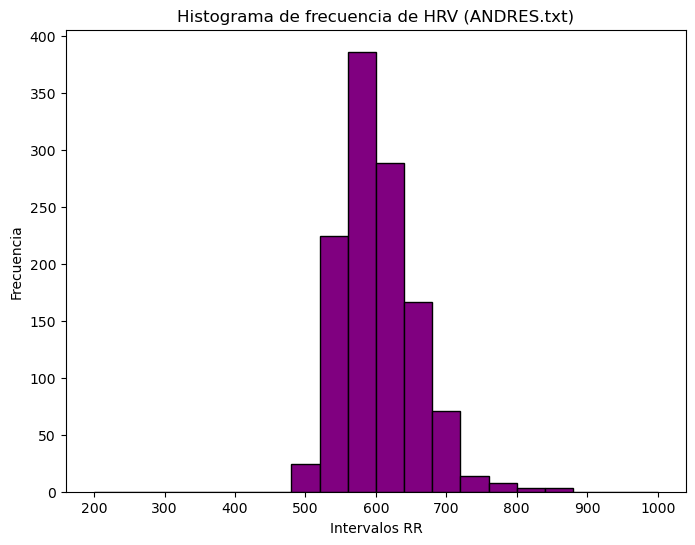

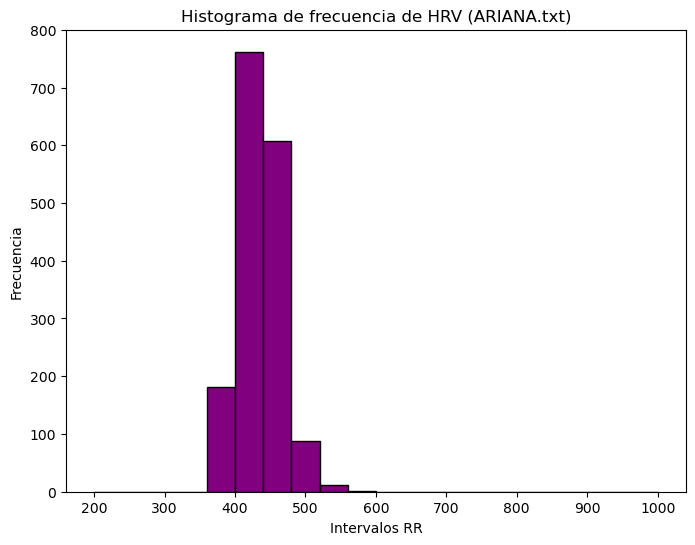

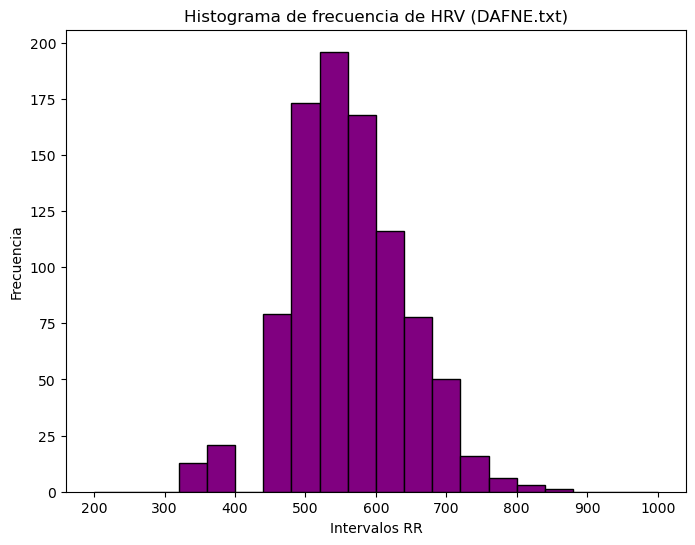

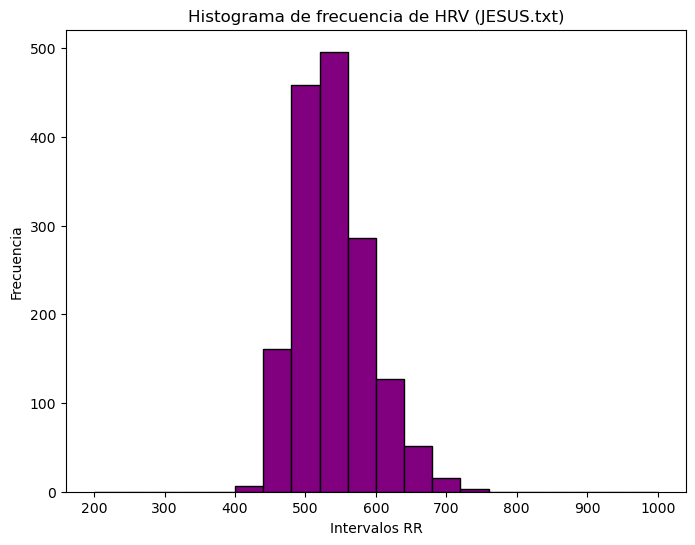

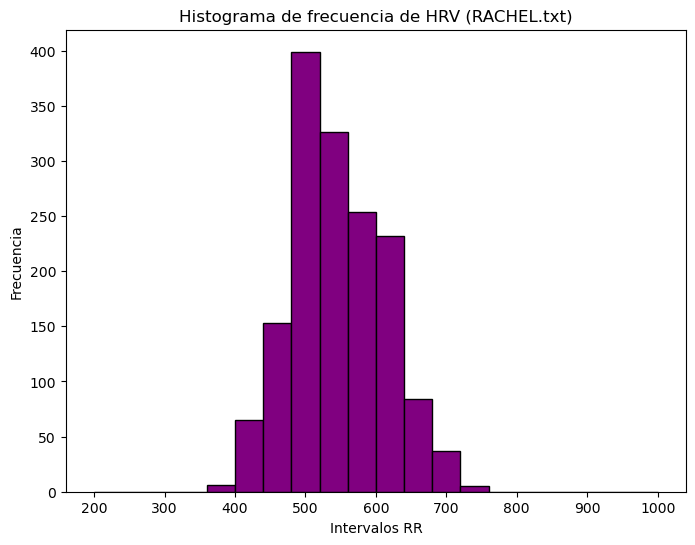

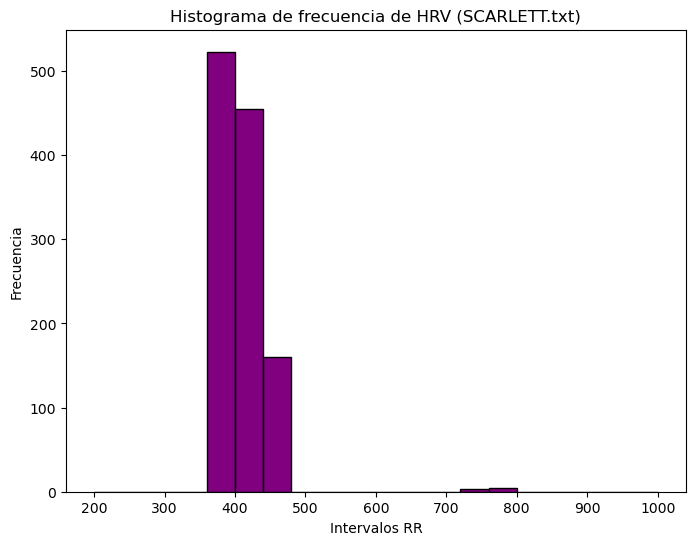

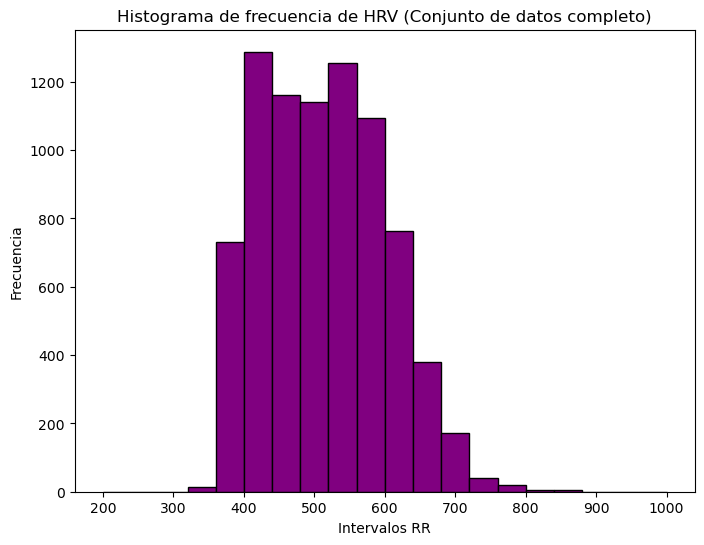

In [5]:
def generar_histograma(datos_hrv, nombre_archivo):
    plt.figure(figsize=(8, 6))
    plt.hist(datos_hrv, range=(200,1000), bins=20, color='purple', edgecolor='black')
    plt.title(f'Histograma de frecuencia de HRV ({nombre_archivo})')
    plt.xlabel('Intervalos RR')
    plt.ylabel('Frecuencia')
    plt.grid(False)
    plt.show()

carpeta_hrv = 'HRV'
archivos_txt = [archivo for archivo in os.listdir(carpeta_hrv) if archivo.lower().endswith('.txt')]
todos_los_datos_hrv = []

for archivo in archivos_txt:
    ruta_archivo = os.path.join(carpeta_hrv, archivo)
    datos_hrv = cargar_datos_desde_archivo(ruta_archivo)
    
    # Generar histograma de frecuencia de HRV para cada archivo
    generar_histograma(datos_hrv, archivo)
    
    # Almacenar datos de HRV para el análisis del conjunto
    todos_los_datos_hrv.extend(datos_hrv)
    
# Generar histograma de frecuencia del conjunto de datos completo
generar_histograma(todos_los_datos_hrv, 'Conjunto de datos completo')

**Observaciones:**

Los intervalos de HRV se concentran en dos rangos principales:

+ Tres participantes: Presentan valores cercanos a los 500 milisegundos o superiores.
+ Dos participantes: Sus valores se concentran por debajo de los 500 milisegundos.

Esta diferencia podría indicar una mayor respuesta al estímulo en los participantes con intervalos más bajos, lo que se asocia a un posible aumento en la ansiedad o el estrés. Sin embargo, esta interpretación es preliminar y no definitiva, ya que se desconoce el intervalo normal de HRV para cada persona.

## <font color='purple'> **2.- Segmentación de Señales** </font>

El análisis exploratorio reveló variaciones en los intervalos de HRV durante las exposiciones. Para identificar las situaciones que provocan estas variaciones, se realizó un segmentado y etiquetado de los videos de los participantes. Se definieron tres categorías principales:

1. **Exponiendo:** El participante presenta un discurso previamente preparado.
2. **Escuchando:** El participante escucha las preguntas de los profesores.
3. **Respondiendo:** El participante responde preguntas de forma improvisada.

El archivo CSV adjunto presenta el segmentado y etiquetado de cada segmento. Este análisis permitirá explorar la relación entre las actividades específicas y los cambios en la HRV.

In [6]:
etiquetado = pd.read_csv('etiquetado.csv')
display(etiquetado.head())

,filename,contexto,inicio,fin
0,ANDRES.txt,Exponiendo,00:08,00:44
1,ANDRES.txt,Escuchando,00:44,00:50
2,ANDRES.txt,Respondiendo,00:50,01:10
3,ANDRES.txt,Escuchando,01:12,01:14
4,ANDRES.txt,Respondiendo,01:14,01:20


Apliquemos el segmentado a los archivos txt con las señales HRV.

In [7]:
def cargar_contexto(etiquetado, tiempo_acumulado, archivo_txt):
    instancia = etiquetado[(etiquetado['filename'] == archivo_txt) & 
                           (etiquetado['inicio'] <= tiempo_acumulado) & 
                           (etiquetado['fin'] >= tiempo_acumulado)]
    if not instancia.empty:
        contexto = instancia['contexto'].values[0]
    else:
        contexto = None
    return contexto

def cargar_contextos_desde_csv(archivo_etiquetado):
    etiquetado = pd.read_csv(archivo_etiquetado)
    etiquetado['inicio'] = etiquetado['inicio'].apply(tiempo_a_segundos)
    etiquetado['fin'] = etiquetado['fin'].apply(tiempo_a_segundos)
    return etiquetado

def calcular_tiempos_acumulados(datos_hrv):
    tiempos_acumulados = [0]
    for valor_hrv in datos_hrv:
        tiempo_segundos = valor_hrv / 1000  # Convertir milisegundos a segundos
        tiempo_acumulado = tiempos_acumulados[-1] + tiempo_segundos
        tiempos_acumulados.append(tiempo_acumulado)
    return tiempos_acumulados[1:]  # Eliminar el primer elemento que es cero

def cargar_datos_desde_carpeta(carpeta_hrv, archivo_etiquetado):
    archivos_txt = [archivo for archivo in os.listdir(carpeta_hrv) if archivo.lower().endswith('.txt')]
    datos_completos = []
    etiquetado = cargar_contextos_desde_csv(archivo_etiquetado)
    
    for archivo_txt in archivos_txt:
        datos_hrv = cargar_datos_desde_archivo(os.path.join(carpeta_hrv, archivo_txt))
        tiempos_acumulados = calcular_tiempos_acumulados(datos_hrv)
        
        contextos = []
        for tiempo_acumulado in tiempos_acumulados:
            contexto = cargar_contexto(etiquetado, tiempo_acumulado, archivo_txt)
            contextos.append(contexto)
        
        datos_archivo = pd.DataFrame({
            'filename': archivo_txt,
            'HRV': datos_hrv,
            'Tiempo_Acumulado': tiempos_acumulados,
            'Contexto': contextos
        })
        
        datos_archivo = datos_archivo.dropna()  # Eliminar filas con contexto nulo
        datos_completos.append(datos_archivo)
    
    return pd.concat(datos_completos, ignore_index=True)

carpeta_hrv = 'HRV'
archivo_etiquetado = 'etiquetado.csv'
datos_completos = cargar_datos_desde_carpeta(carpeta_hrv, archivo_etiquetado)
display(datos_completos.head())

,filename,HRV,Tiempo_Acumulado,Contexto
0,ANDRES.txt,591.0,8.555,Exponiendo
1,ANDRES.txt,607.0,9.162,Exponiendo
2,ANDRES.txt,624.0,9.786,Exponiendo
3,ANDRES.txt,596.0,10.382,Exponiendo
4,ANDRES.txt,581.0,10.963,Exponiendo


Observemos los histogramas correspondientes a cada contexto para ver si se observa alguna tendencia global (entre todos los participantes).

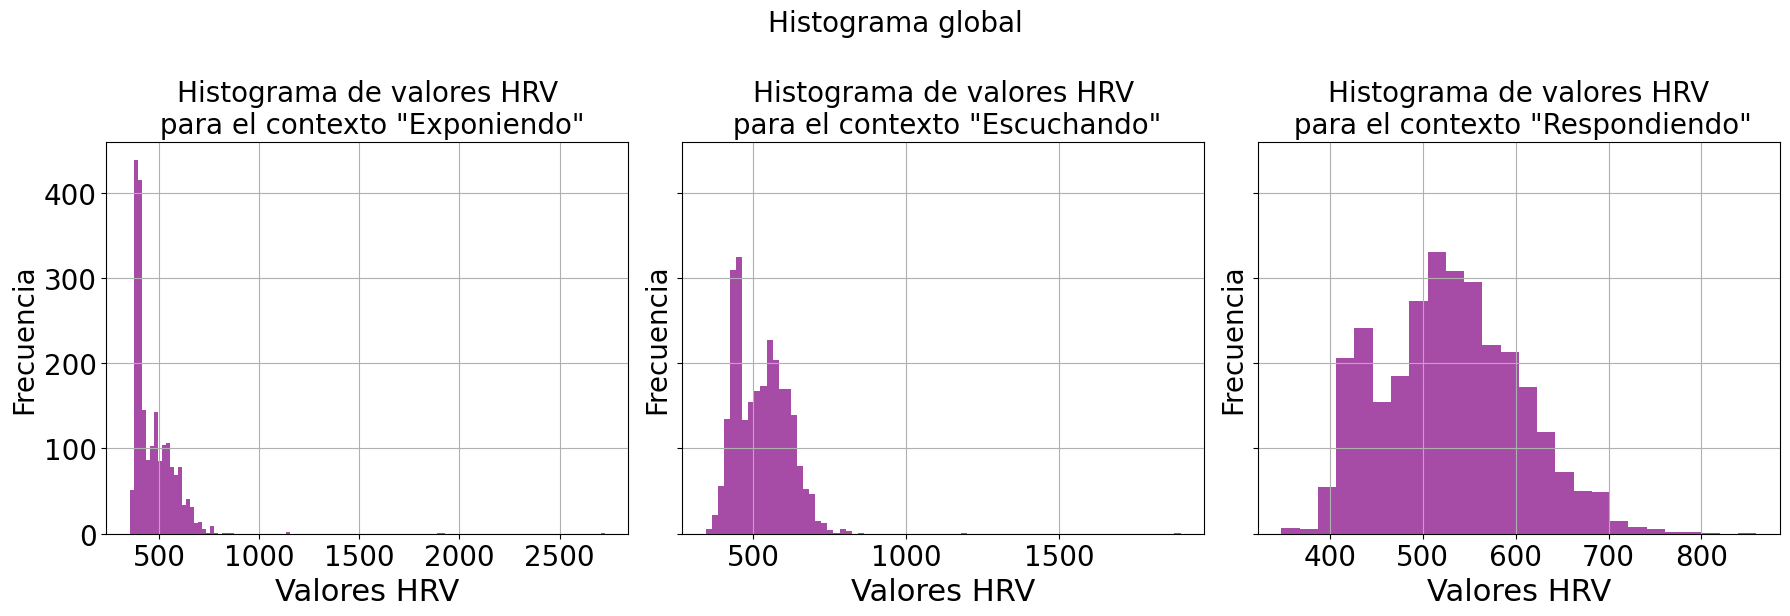

In [8]:
# Obtener todos los contextos únicos
contextos_unicos = datos_completos['Contexto'].unique()

# Calcular el número total de subplots necesarios
num_subplots = len(contextos_unicos)

# Crear una figura y subplots
fig, axs = plt.subplots(1, num_subplots, figsize=(6*num_subplots, 6), sharey=True)

# Título global para la figura
plt.suptitle(f'Histograma global', fontsize=20, y=1.02)

# Especificar el ancho deseado para los bins
bin_width = 20  

# Iterar sobre cada contexto y crear un histograma para cada uno en un subplot diferente
for i, contexto in enumerate(contextos_unicos):
    datos_contexto = datos_completos[datos_completos['Contexto'] == contexto]
    
    # Calcular el número de bins necesario para cubrir todo el rango de datos
    min_value = datos_contexto['HRV'].min()
    max_value = datos_contexto['HRV'].max()
    num_bins = int(np.ceil((max_value - min_value) / bin_width))

    axs[i].hist(datos_contexto['HRV'], bins=num_bins, alpha=0.7, color='purple')
    axs[i].set_title(f'Histograma de valores HRV\n para el contexto "{contexto}"', fontsize=20)
    axs[i].set_xlabel('Valores HRV', fontsize=22)
    axs[i].set_ylabel('Frecuencia', fontsize=20)
    axs[i].tick_params(axis='both', which='major', labelsize=20)
    axs[i].grid(True)

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

**Observaciones:**

Al analizar los intervalos de HRV en las diferentes categorías de actividad, se observan las siguientes tendencias:

+ Exponiendo: La mayoría de los participantes presenta un ritmo cardíaco más rápido, con valores promedio alrededor de 0.4 segundos entre latidos.
+ Escuchando: El ritmo cardíaco disminuye brevemente a valores entre 0.5 y 0.6 segundos entre latidos.
+ Respondiendo: Se observa una mayor concentración de valores superiores a 0.5 segundos entre latidos.

Estas tendencias sugieren que la actividad más estresante para los participantes es la exposición, seguida por la respuesta a preguntas y finalmente la escucha de preguntas.

Observemos ahora los histogramas por participante. 

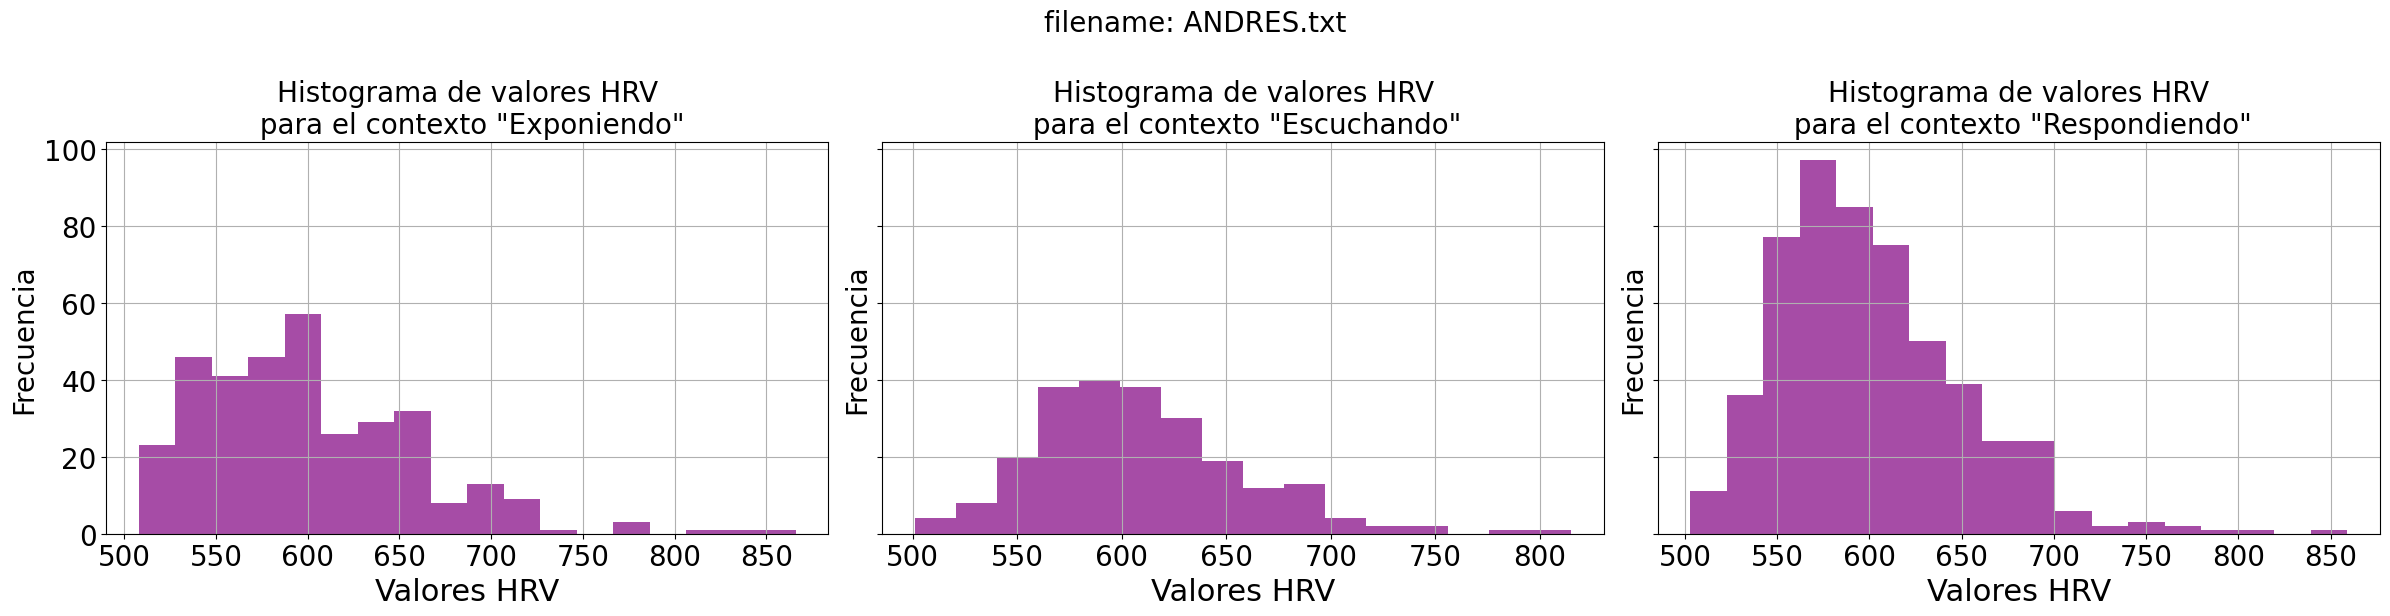

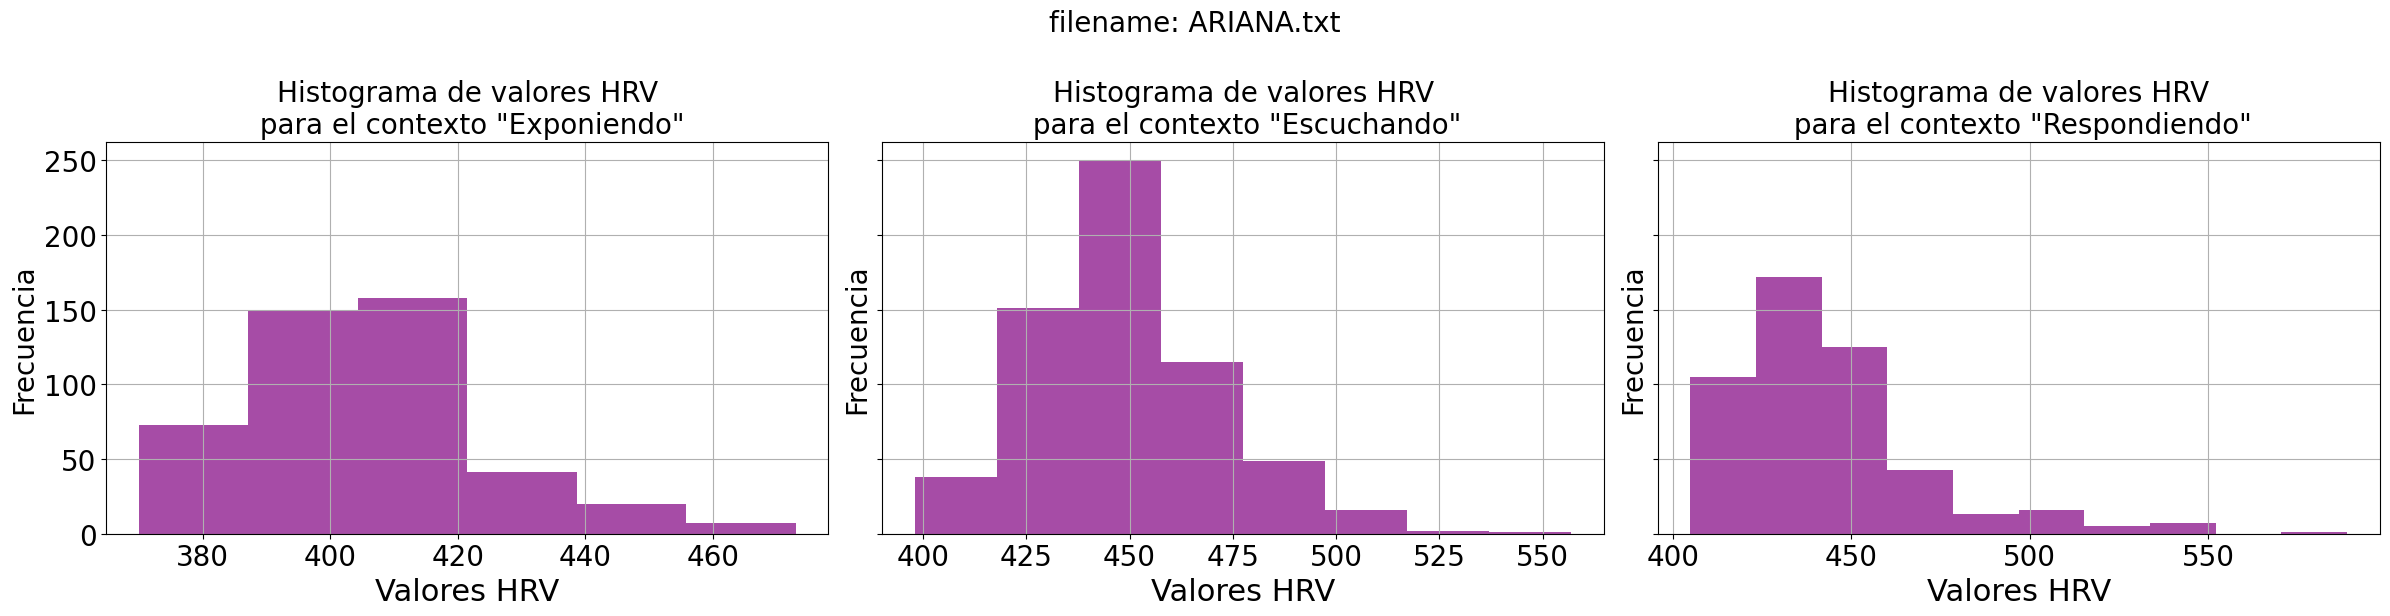

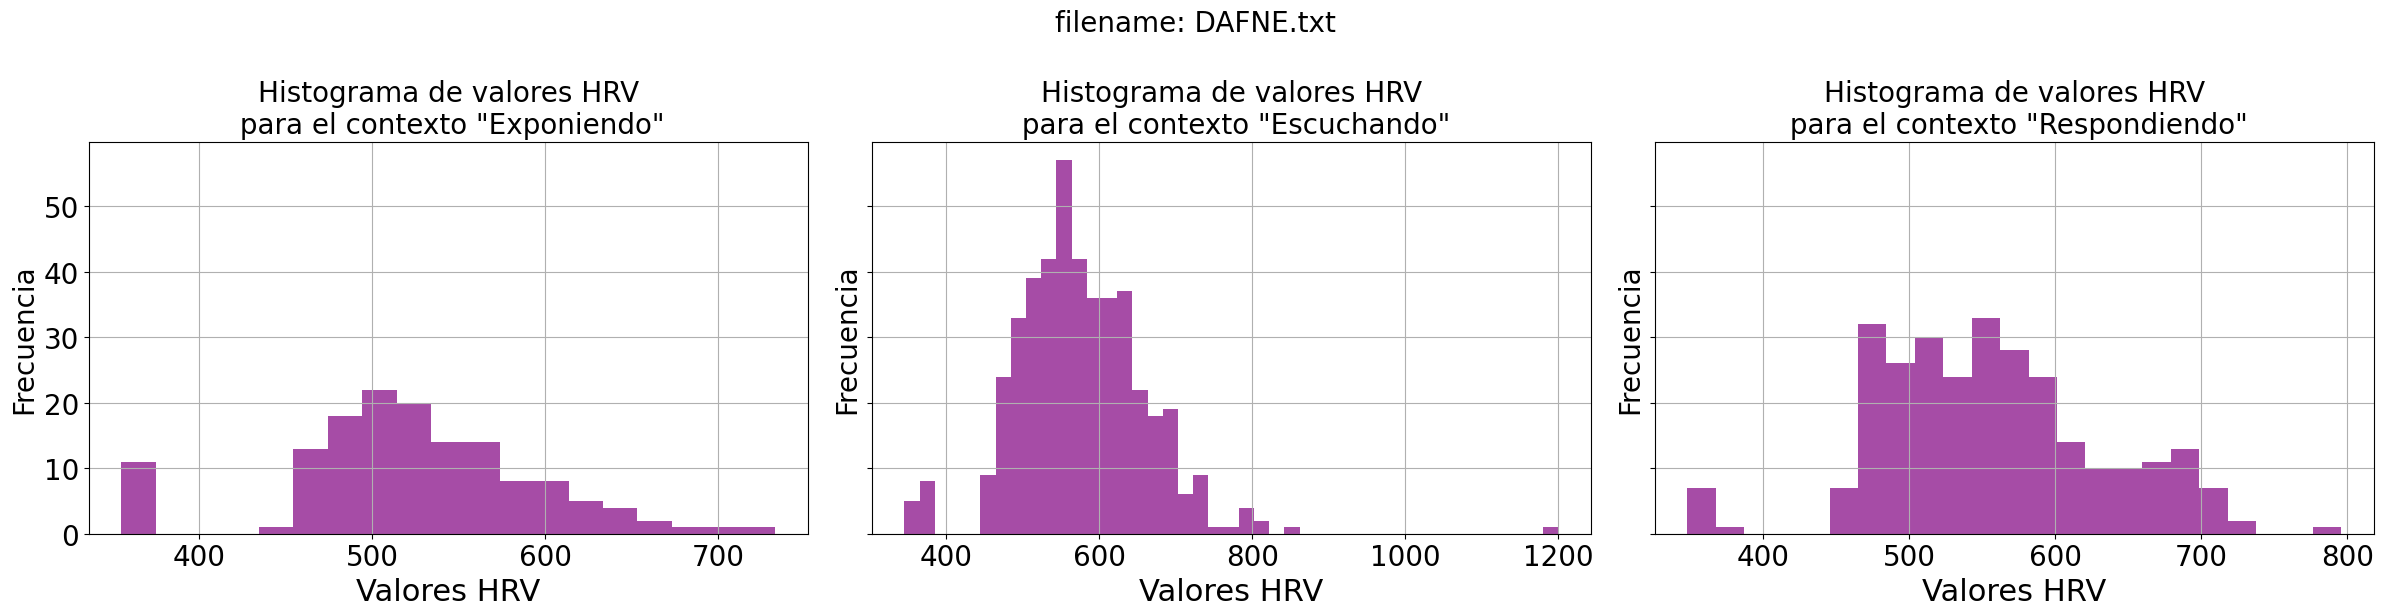

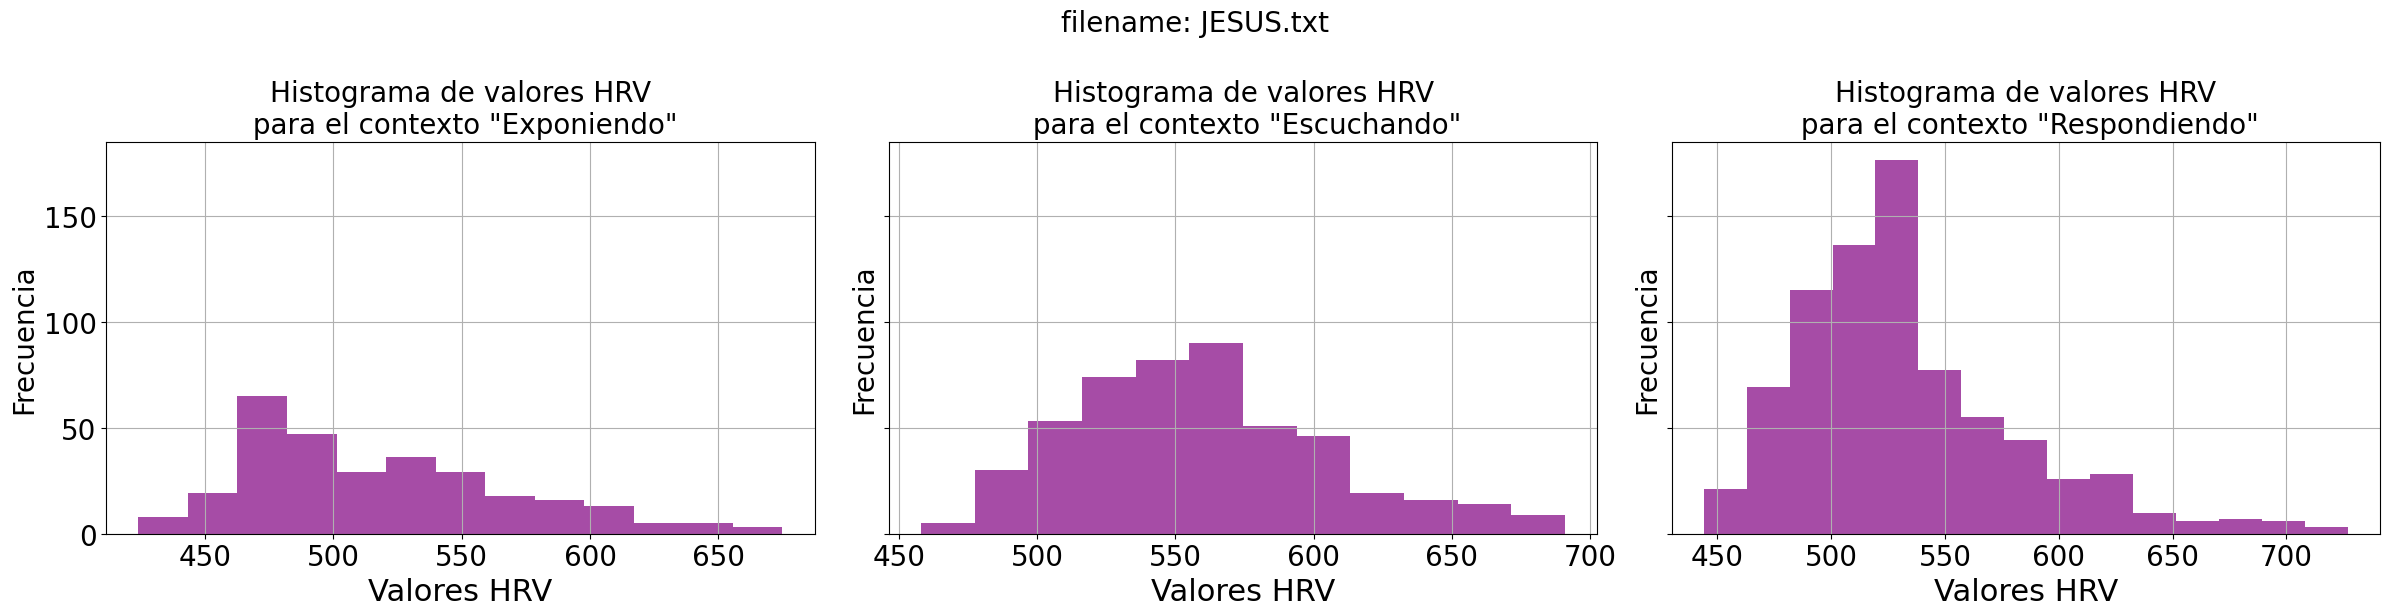

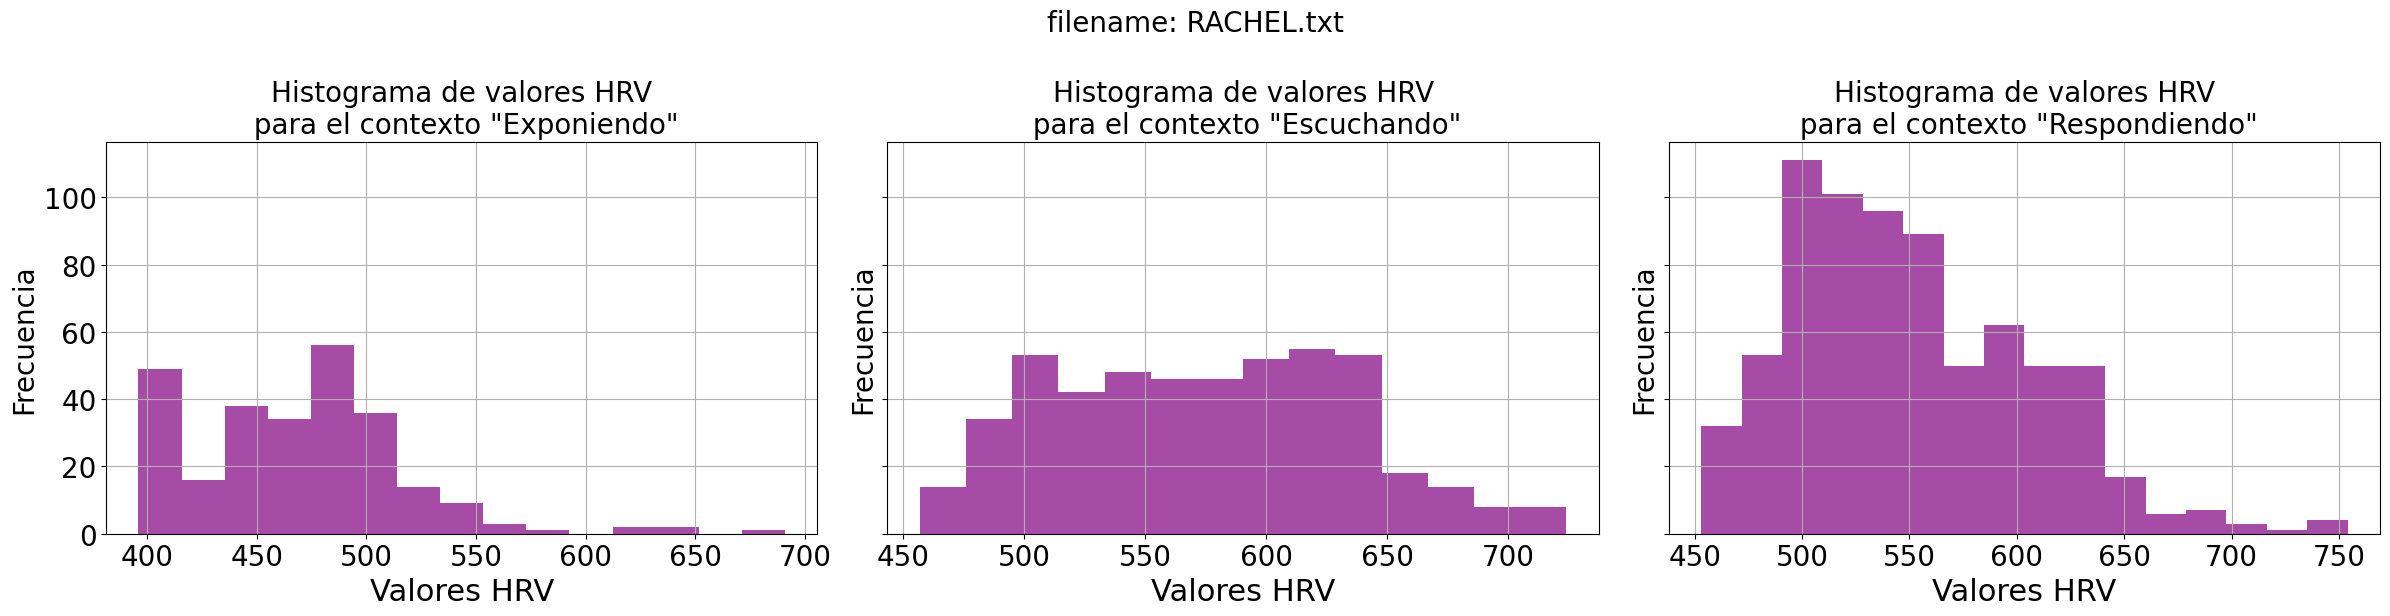

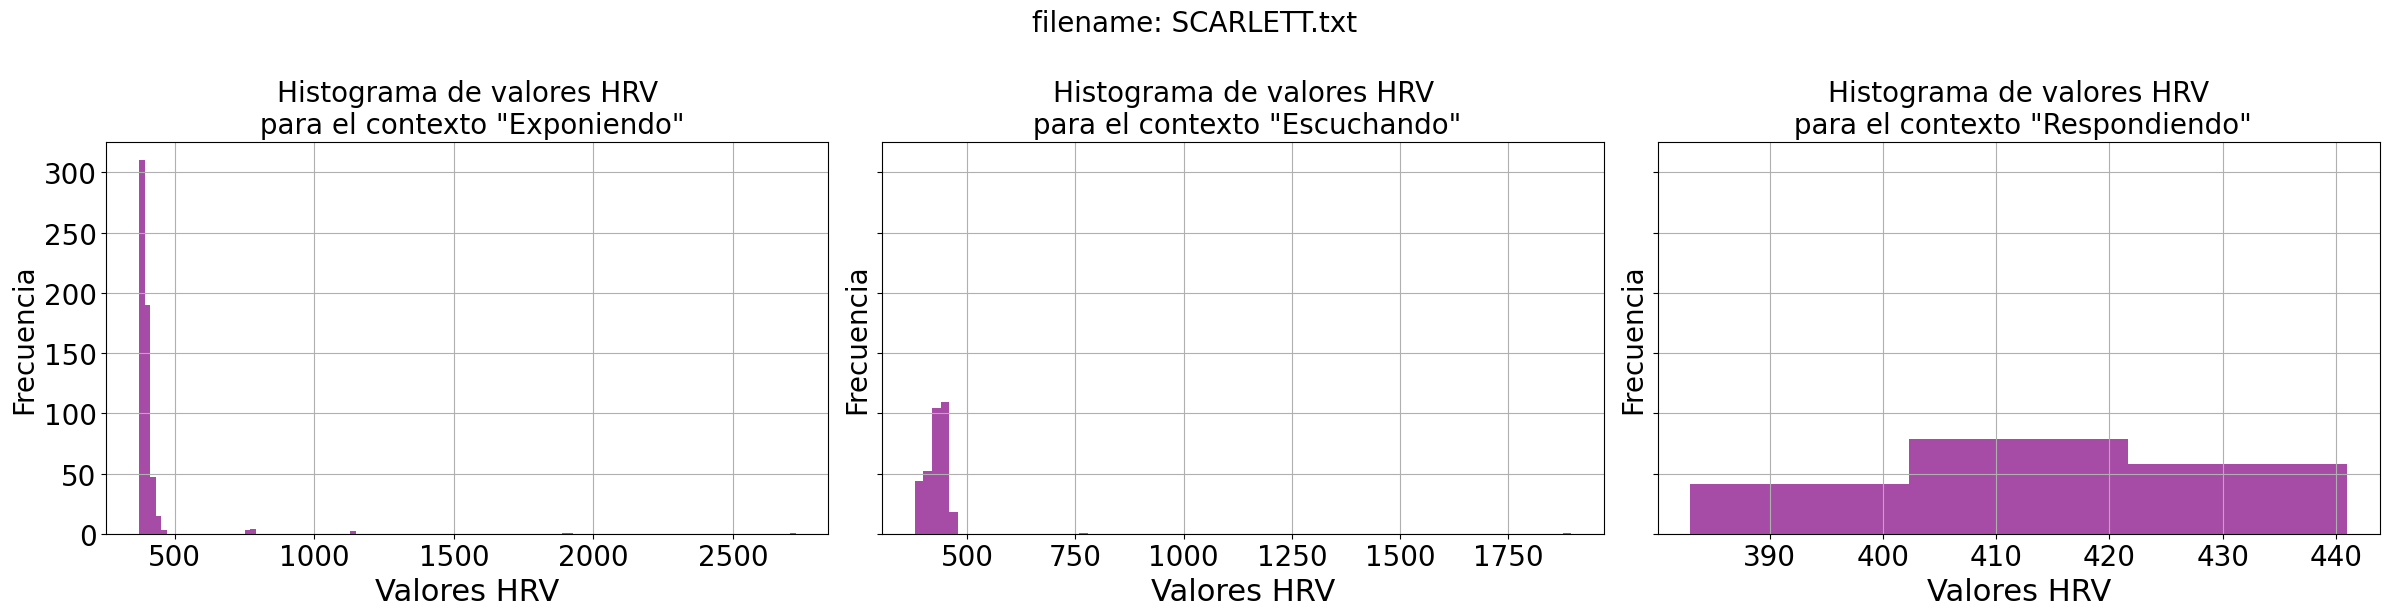

In [9]:
# Obtener todos los archivos únicos
archivos_unicos = datos_completos['filename'].unique()

# Iterar sobre cada archivo
for archivo in archivos_unicos:
    # Obtener los datos correspondientes a este archivo
    datos_archivo = datos_completos[datos_completos['filename'] == archivo]
    
    # Obtener todos los contextos únicos para este archivo
    contextos_unicos = datos_archivo['Contexto'].unique()

    # Calcular el número total de subplots necesarios para este archivo
    num_subplots = len(contextos_unicos)

    # Crear una figura y subplots con tamaño personalizado para este archivo
    fig, axs = plt.subplots(1, num_subplots, figsize=(8*num_subplots, 6), sharey=True)
    
    # Título global para la figura
    plt.suptitle(f'filename: {archivo}', fontsize=20, y=1.02)
    
    # Iterar sobre cada contexto y crear un histograma para cada uno en un subplot diferente
    for i, contexto in enumerate(contextos_unicos):
        datos_contexto = datos_archivo[datos_archivo['Contexto'] == contexto]
        
        # Calcular el número de bins necesario para cubrir todo el rango de datos
        min_value = datos_contexto['HRV'].min()
        max_value = datos_contexto['HRV'].max()
        num_bins = int(np.ceil((max_value - min_value) / bin_width))

        axs[i].hist(datos_contexto['HRV'], bins=num_bins, alpha=0.7, color='purple')
        axs[i].set_title(f'Histograma de valores HRV\n para el contexto "{contexto}"', fontsize=20)
        axs[i].set_xlabel('Valores HRV', fontsize=22)
        axs[i].set_ylabel('Frecuencia', fontsize=20)
        axs[i].tick_params(axis='both', which='major', labelsize=20)
        axs[i].grid(True)
    
    # Ajustar espaciado entre subplots
    plt.tight_layout()
    
    # Mostrar la figura para este archivo
    plt.show()

**Observaciones:**

Si bien se observan algunas coincidencias entre los participantes en las diferentes categorías de actividad, también hay diferencias notables. Por ejemplo, al responder preguntas, Ariana presenta un ritmo cardíaco más rápido que Dafne, quien tiende a tener ritmos ligeramente más lentos.

Esta variabilidad interindividual sugiere que la clasificación precisa de cada contexto mediante un clasificador único podría ser difícil. No obstante, se procederá a la extracción de características de la HRV para evaluar si es posible obtener características más útiles para lograr esta clasificación.

## <font color='purple'> **3.- Extracción de características** </font>

Se extraerán las series temporales de la HRV a partir de intervalos RR (entre latidos cardíacos) en milisegundos. Posteriormente, se calcularán las siguientes características del HRV:

1. **SDNN (Desviación Estándar de los Intervalos RR)**:
   - La SDNN mide la variabilidad total de los intervalos RR.
   - Cuanto mayor sea la SDNN, mayor será la variabilidad en los ritmos cardíacos.

2. **RMSSD (Raíz Cuadrada de las Diferencias Cuadráticas Sucesivas)**:
   - Representa la variabilidad a corto plazo.
   - Un valor alto indica una respuesta rápida del sistema nervioso autónomo.

3. **NN50 y pNN50**:
   - NN50 es el número de diferencias sucesivas mayores a 50 ms entre intervalos RR.
   - pNN50 es el porcentaje de NN50 en relación con el total de intervalos RR.
   - Ambos indican variabilidad a corto plazo.

4. **SD1 y SD2 (Parámetros del Espacio de Poincaré)**:
   - SD1 mide la dispersión de los puntos en la dirección perpendicular al eje de identidad.
   - SD2 mide la dispersión en la dirección paralela al eje de identidad.
   - Proporcionan información sobre la variabilidad a largo plazo.

5. **LF (Baja Frecuencia) y HF (Alta Frecuencia)**:
   - Representan componentes de la variabilidad en diferentes bandas de frecuencia.
   - LF está relacionada con la actividad simpática y parcialmente con la actividad parasimpática.
   - HF está relacionada principalmente con la actividad parasimpática.

6. **LF/HF Ratio**:
   - Proporciona una estimación del equilibrio entre el sistema simpático y parasimpático.
   - Un valor alto sugiere predominio simpático.

7. **TINN (Triangular Interpolation of NN intervals)**:
   - Es una medida de la variabilidad a largo plazo.

8. **Moda, Entropía de Shannon, Correlación, CV, PEI, Mediana NNI, Rango NNI, Asimetría, Curtosis y Área bajo la curva**:
   - Estas características proporcionan información adicional sobre la forma y distribución de los intervalos RR.
   
9. **ContextoLongitud**: 
    - Es la longitud temporal de un segmento de contexto específico, medida en segundos. 



In [10]:
def calcular_caracteristicas_hrv(datos_completos):
    caracteristicas = []
    
    # Inicializar variables para mantener el contexto anterior y la serie temporal actual
    contexto_anterior = None
    serie_temporal_actual = []
    filename = None
    contexto = None
    
    for i, row in datos_completos.iterrows():
        # Verificar si hay un cambio de contexto para iniciar un nuevo segmento
        if row['Contexto'] != contexto_anterior:
            # Si hay un cambio de contexto y la serie temporal actual no está vacía,
            # calcular las características de HRV y guardarlas en el DataFrame de características
            if serie_temporal_actual:
                caracteristicas.extend(calcular_caracteristicas_serie(serie_temporal_actual, filename, contexto))
                # Reiniciar la serie temporal actual
                serie_temporal_actual = []
        
        # Agregar el valor HRV actual a la serie temporal actual
        serie_temporal_actual.append(row['HRV'])
        
        # Actualizar el contexto anterior para la próxima iteración
        contexto_anterior = row['Contexto']
        filename = row['filename']
        contexto = row['Contexto']
    
    # Calcular características para la última serie temporal si existe
    if serie_temporal_actual:
        caracteristicas.extend(calcular_caracteristicas_serie(serie_temporal_actual, filename, contexto))
    
    return pd.DataFrame(caracteristicas)

def calcular_caracteristicas_serie(serie_temporal, filename, contexto):
    caracteristicas_serie = []
    rr_intervals = np.array(serie_temporal)  # Convertir la serie temporal en un array
    
    sd1, sd2 = np.std(np.diff(rr_intervals)), np.std(np.diff(np.diff(rr_intervals)))
    
    # Guardar las características en una lista
    caracteristicas_serie.append({
        'filename': filename,
        'Contexto': contexto,
        # Calcular las características del HRV
        'SDNN': np.std(rr_intervals),
        'RMSSD': np.sqrt(np.mean(np.diff(rr_intervals) ** 2)),
        'NN50': np.sum(np.abs(np.diff(rr_intervals)) > 50),
        'pNN50': (np.sum(np.abs(np.diff(rr_intervals)) > 50)) / len(rr_intervals),
        'SD1': sd1,
        'SD2': sd2,
        'LF': np.sum((rr_intervals > 0.04) & (rr_intervals < 0.15)),
        'HF': np.sum(rr_intervals > 0.15),
        'LF/HF Ratio': (np.sum((rr_intervals > 0.04) & (rr_intervals < 0.15))) / (np.sum(rr_intervals > 0.15)),
        'TINN': np.max(np.diff(np.sort(rr_intervals))),
        'Mode': np.argmax(np.bincount(rr_intervals.astype(int))),
        'Shannon Entropy': -np.sum((rr_intervals / np.sum(rr_intervals)) * np.log(rr_intervals / np.sum(rr_intervals))),
        'Correlation': np.corrcoef(rr_intervals[:-1], rr_intervals[1:])[0, 1],
        'CV': np.std(rr_intervals) / np.mean(rr_intervals),
        'PEI': np.sum(np.abs(np.diff(rr_intervals)) > 20) / len(rr_intervals),
        'Median NNI': np.median(rr_intervals),
        'Range NNI': np.max(rr_intervals) - np.min(rr_intervals),
        'Skewness': np.sum((rr_intervals - np.mean(rr_intervals)) ** 3) / (len(rr_intervals) * np.std(rr_intervals) ** 3),
        'Kurtosis': np.sum((rr_intervals - np.mean(rr_intervals)) ** 4) / (len(rr_intervals) * np.std(rr_intervals) ** 4),
        'Area Under Curve': np.trapz(rr_intervals),
        'LongitudContexto': np.sum(rr_intervals)/1000
    })
    
    return caracteristicas_serie


características_hrv = calcular_caracteristicas_hrv(datos_completos)
display(características_hrv)

,filename,Contexto,SDNN,RMSSD,NN50,pNN50,SD1,SD2,LF,HF,...,Shannon Entropy,Correlation,CV,PEI,Median NNI,Range NNI,Skewness,Kurtosis,Area Under Curve,LongitudContexto
0,ANDRES.txt,Exponiendo,39.441233,21.840330,2,0.032258,21.838109,22.615260,0,62,...,4.124793,0.847908,0.068744,0.258065,571.0,169.0,0.472851,2.493344,34971.5,35.572
1,ANDRES.txt,Escuchando,22.484154,19.393298,0,0.000000,19.110468,13.414567,0,11,...,2.397122,0.573847,0.039440,0.181818,567.0,85.0,0.496403,3.060908,5667.5,6.271
2,ANDRES.txt,Respondiendo,42.696787,29.416195,3,0.090909,29.409554,28.856565,0,33,...,3.493991,0.768825,0.071425,0.484848,593.0,164.0,0.652003,2.579826,19143.0,19.727
3,ANDRES.txt,Escuchando,17.720045,25.544080,0,0.000000,16.500000,0.000000,0,3,...,1.098233,1.000000,0.027644,0.333333,630.0,39.0,0.691937,1.500000,1276.5,1.923
4,ANDRES.txt,Respondiendo,36.031792,20.843331,0,0.000000,18.746522,16.100757,0,10,...,2.300703,0.886839,0.061815,0.400000,580.0,120.0,0.792369,2.743837,5211.0,5.829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,SCARLETT.txt,Escuchando,1.400000,1.855921,0,0.000000,1.852592,3.427827,0,10,...,2.302579,0.115045,0.003467,0.000000,404.0,5.0,0.795918,3.351520,3635.5,4.038
220,SCARLETT.txt,Respondiendo,5.821512,3.901567,0,0.000000,3.281072,4.166458,0,10,...,2.302483,0.868312,0.014342,0.000000,404.0,19.0,1.246220,3.710661,3648.5,4.059
221,SCARLETT.txt,Escuchando,12.709347,5.199760,0,0.000000,5.199023,6.328532,0,81,...,4.394039,0.915414,0.028716,0.000000,440.0,55.0,0.601253,2.876661,35423.5,35.849
222,SCARLETT.txt,Respondiendo,7.056185,3.246080,0,0.000000,3.237141,4.405893,0,55,...,4.007191,0.895030,0.016854,0.000000,418.0,26.0,0.096636,1.942701,22607.5,23.026


Observemos si los contextos son seperables aplicando PCA como método de visualización.

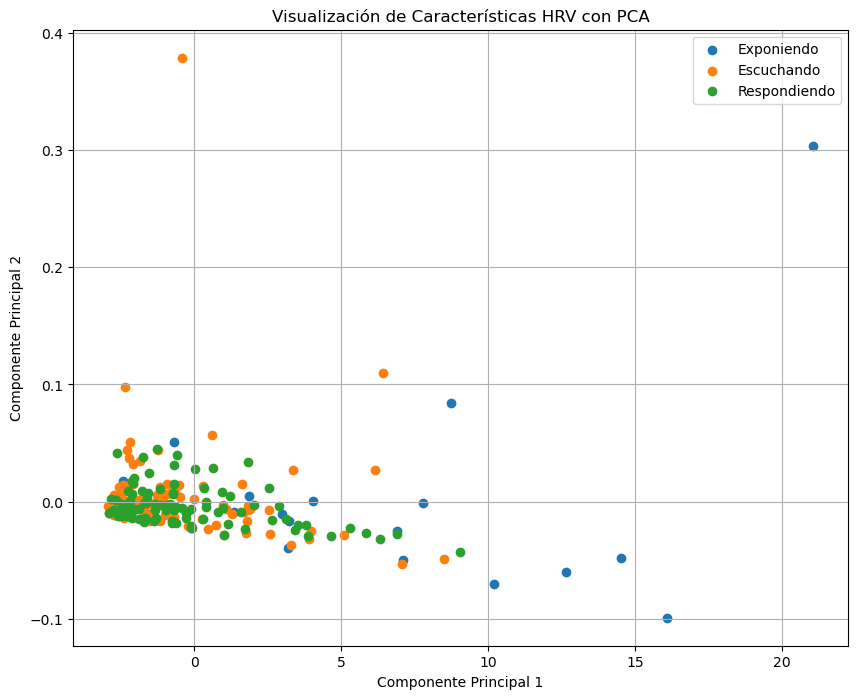

In [11]:
X = características_hrv.drop(['Contexto', 'filename'], axis=1)

# Imputar los valores faltantes con la media
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalizar los datos
X_normalized = (X_imputed - X_imputed.mean()) / X_imputed.std()

# Aplicar PCA para reducir la dimensionalidad a 2 componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Crear un gráfico de dispersión coloreado por contexto
plt.figure(figsize=(10, 8))
for contexto in características_hrv['Contexto'].unique():
    indices = características_hrv['Contexto'] == contexto
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=contexto)

plt.title('Visualización de Características HRV con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()

Además observemos el histograma de los contextos para ver que tan desbalanceadas están las clases. 

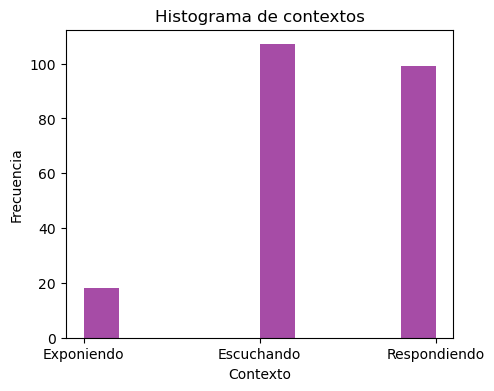

In [12]:
plt.figure(figsize=(5, 4))
características_hrv['Contexto'].hist(alpha=0.7, color='purple')
plt.title('Histograma de contextos')
plt.xlabel('Contexto')
plt.ylabel('Frecuencia')
plt.grid(False)
plt.show()

**Observaciones:** 
+ Se observa un desequilibrio en la cantidad de datos disponibles para cada categoría de actividad. Este desequilibrio se debe a que los participantes dedicaban más tiempo a la exposición, lo que se traduce en una menor cantidad de instancias de mayor duración para las otras categorías (escuchar y responder preguntas).

A continuación, se analiza el diagrama de cajas de los valores de HRV del dataframe `datos_completos` para evaluar la posibilidad de separarlos mediante umbrales. Este análisis permitirá determinar si existen diferencias significativas en la HRV entre las diferentes categorías de actividad.

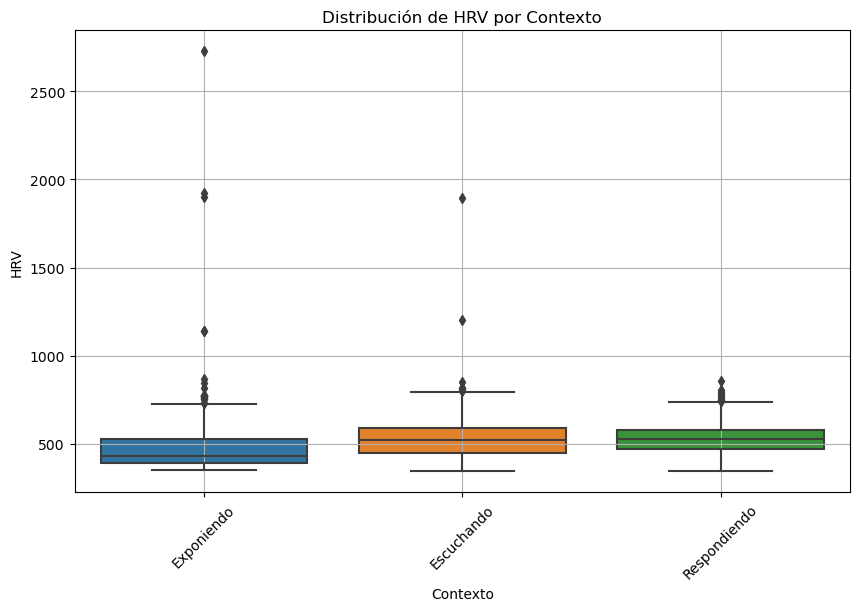

In [13]:
# Crear un gráfico de caja y bigotes para visualizar la distribución de los valores HRV por contexto
plt.figure(figsize=(10, 6))
sns.boxplot(x='Contexto', y='HRV', data=datos_completos)
plt.title('Distribución de HRV por Contexto')
plt.xlabel('Contexto')
plt.ylabel('HRV')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Observaciones:** 
+ Se observa una diferencia entre la cantidad de características e instancias disponibles. Al aumentar el número de características, se reduce la cantidad de instancias, mientras que al tener más instancias, solo se cuenta con la HRV como característica. No obstante, se construirán clasificadores utilizando tanto las características extraídas como solo la HRV como característica para evaluar la capacidad de los algoritmos de inferencia para encontrar patrones entre los valores de HRV y el contexto (etiqueta).

+ Adicionalmente, se realizará una selección de características para mejorar la separabilidad de los datos. El análisis de componentes principales (PCA) no parece indicar un patrón claro para separar los contextos, por lo que se buscarán subconjuntos de características más discriminatorias.

+ Los diagramas de cajas sugieren que la acción de "Exponer" podría ser distinguible de las demás, ya que sus valores de HRV se encuentran en un rango inferior. Sin embargo, las categorías "Escuchando" y "Respondiendo" presentan valores muy similares, lo que indica que un clasificador podría tener dificultades para diferenciarlas.

## <font color='purple'> **4.- Selección de características** </font>

Realicemos la selección de características utilizando la técnica de Ganancia de Información. 

In [14]:
características = características_hrv.dropna()
X = características.drop(['Contexto', 'filename'], axis=1)
y = características['Contexto']

In [15]:
X_new = mutual_info_classif(X, y)
feat_imp = pd.Series(X_new, características.columns[2:]).sort_values(ascending=False)
display(feat_imp)

Shannon Entropy     0.105196
Kurtosis            0.090346
LongitudContexto    0.077695
Area Under Curve    0.066670
HF                  0.065112
Correlation         0.055580
LF/HF Ratio         0.036385
Median NNI          0.024935
pNN50               0.021395
NN50                0.009983
TINN                0.003883
SD2                 0.003685
Skewness            0.000000
Range NNI           0.000000
SDNN                0.000000
PEI                 0.000000
CV                  0.000000
RMSSD               0.000000
LF                  0.000000
SD1                 0.000000
Mode                0.000000
dtype: float64

In [16]:
# Seleccionamos las features más importantes
feat_imp_sorted = feat_imp[feat_imp > 0.01]
display(feat_imp_sorted)

Shannon Entropy     0.105196
Kurtosis            0.090346
LongitudContexto    0.077695
Area Under Curve    0.066670
HF                  0.065112
Correlation         0.055580
LF/HF Ratio         0.036385
Median NNI          0.024935
pNN50               0.021395
dtype: float64

In [17]:
X_selected = características_hrv[feat_imp_sorted.index]
df_caracteristicas_hrv = pd.concat([características_hrv[['filename']], X_selected, y], axis=1)
display(df_caracteristicas_hrv.head())

,filename,Shannon Entropy,Kurtosis,LongitudContexto,Area Under Curve,HF,Correlation,LF/HF Ratio,Median NNI,pNN50,Contexto
0,ANDRES.txt,4.124793,2.493344,35.572,34971.5,62,0.847908,0.0,571.0,0.032258,Exponiendo
1,ANDRES.txt,2.397122,3.060908,6.271,5667.5,11,0.573847,0.0,567.0,0.000000,Escuchando
2,ANDRES.txt,3.493991,2.579826,19.727,19143.0,33,0.768825,0.0,593.0,0.090909,Respondiendo
3,ANDRES.txt,1.098233,1.500000,1.923,1276.5,3,1.000000,0.0,630.0,0.000000,Escuchando
4,ANDRES.txt,2.300703,2.743837,5.829,5211.0,10,0.886839,0.0,580.0,0.000000,Respondiendo


**Observación:**
+ Se observa que las altas frecuencias (HF) de la HRV son relevantes para la diferenciación entre contextos, mientras que las bajas frecuencias (LF) no lo son.

## <font color='purple'> **5.- Construcción y evaluación de los modelos** </font>

En esta sección se entrenarán y evaluarán cinco modelos de aprendizaje automático para la diferenciación entre contextos. La evaluación se realizará mediante validación cruzada con "Stratified Shuffle Split", un método que tiene en cuenta el desbalance de clases presente en el conjunto de datos. Los algoritmos de inferencia que se utilizarán son:

+ Naive Bayes
+ Regresión logística
+ Random Forest
+ Gradient Boosting
+ Support Vector Machines
+ KNN


### <font color='purple'> **5.1 Validación cruzada con Stratified Shuffle Split** </font>

Definimos un par de funciones. 

In [18]:
def validation_predict(model, df, num_folds):

    # Se divide el conjunto de datos en variables independientes y variable dependiente
    X = df.drop(['Contexto', 'filename'], axis=1)
    if 'Tiempo_Acumulado' in X.columns:
        X = X.drop('Tiempo_Acumulado', axis=1)
    y = df['Contexto']
    
    # Se crea un objeto StratifiedShuffleSplit para dividir los datos originales en folds estratificados
    sss = StratifiedShuffleSplit(n_splits=num_folds, test_size=1/num_folds, random_state=42)
        
    # Se inicializa una lista para almacenar las predicciones de cada fold
    predictions = []
    # Se inicializa una lista para almacenar las etiquetas originales
    labels = []
    indexes = []

    # Realiza la validación cruzada y entrena el modelo en cada fold
    for train_index, test_index in sss.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
         
        if isinstance(model, SVC):
            # Convertir la matriz dispersa a matriz densa antes de ajustar el modelo
            X_train = check_array(X_train, accept_sparse='csr', force_all_finite=False)
            # Ajustar el modelo sin feature_names
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train)

        # Se realizan las predicciones en el conjunto de prueba (datos originales) de este fold
        fold_predictions = model.predict(X_test)

        # Se almacenan las predicciones y etiquetas de cada fold en las listas
        predictions.extend(fold_predictions)
        labels.extend(y_test)
        indexes.extend(test_index)
    
    
    df_predictions = pd.Series(predictions)
    df_labels = pd.Series(labels)
    df_indexes = pd.Series(indexes)
    
    # Se regresan los datos originales con los datos predichos durante la validación cruzada
    return df_labels, df_predictions, df_indexes

In [19]:
def cross_validation_classification_models(df, num_folds):
    
    models = {    
        'Naive Bayes': GaussianNB(),
        'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=24),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),
        'SVM': SVC(kernel='linear', decision_function_shape='ovr'),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    
    predictions = {} # Diccionario para almacenar las predicciones
    
    # Evaluamos el rendimiento de cada modelo
    for model_name, model in models.items():
        
        # Utilizamos cross_val_predict para obtener las predicciones
        y, predicted, indexes = validation_predict(model, df, num_folds)
        
        # Calcula y muestra las métricas
        print("Resultados de validación cruzada para {}:".format(model.__class__.__name__))
        print("Exactitud:", accuracy_score(y, predicted))
        print("Reporte de clasificación:")
        print(classification_report(y, predicted))

        # Calcula y muestra la matriz de confusión como una imagen
        conf_mat = confusion_matrix(y, predicted)
        plt.figure(figsize=(3, 3))
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Purples", cbar=False)
        plt.title("Matriz de Confusión")
        plt.xlabel("Predicción")
        plt.ylabel("Valor Real")
        plt.show()
        print()
        
        
        # Almacenamos las métricas en el diccionario
        predictions[model_name] = {
            'index': indexes,
            'real': y,
            'predicted': predicted
        }
        
    return predictions

### <font color='purple'> **5.2 Evaluación de modelos con features extraídas** </font>

Analicemos los resultados de la validación cruzada para los 5 algoritmos de inferencia aplicados a las características extraídas de la HRV. Esta evaluación nos permitirá evaluar el desempeño de cada algoritmo en la clasificación de los diferentes contextos.

Resultados de validación cruzada para GaussianNB:
Exactitud: 0.5478260869565217
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.61      0.39      0.48       110
  Exponiendo       0.48      0.60      0.53        20
Respondiendo       0.53      0.71      0.60       100

    accuracy                           0.55       230
   macro avg       0.54      0.57      0.54       230
weighted avg       0.56      0.55      0.54       230



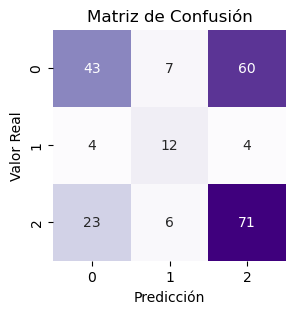


Resultados de validación cruzada para LogisticRegression:
Exactitud: 0.5739130434782609
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.56      0.79      0.66       110
  Exponiendo       0.85      0.55      0.67        20
Respondiendo       0.54      0.34      0.42       100

    accuracy                           0.57       230
   macro avg       0.65      0.56      0.58       230
weighted avg       0.58      0.57      0.55       230



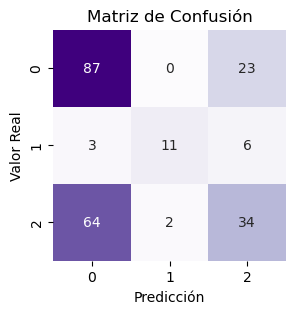


Resultados de validación cruzada para RandomForestClassifier:
Exactitud: 0.6043478260869565
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.63      0.59      0.61       110
  Exponiendo       0.83      0.50      0.62        20
Respondiendo       0.56      0.64      0.60       100

    accuracy                           0.60       230
   macro avg       0.67      0.58      0.61       230
weighted avg       0.62      0.60      0.61       230



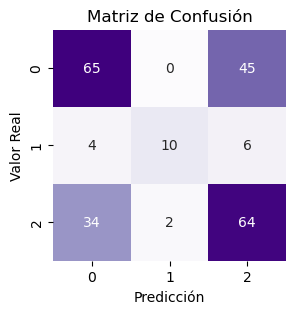


Resultados de validación cruzada para GradientBoostingClassifier:
Exactitud: 0.5434782608695652
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.57      0.60      0.58       110
  Exponiendo       0.45      0.25      0.32        20
Respondiendo       0.52      0.54      0.53       100

    accuracy                           0.54       230
   macro avg       0.52      0.46      0.48       230
weighted avg       0.54      0.54      0.54       230



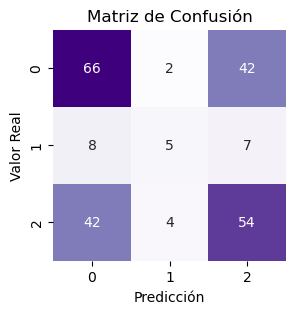


Resultados de validación cruzada para SVC:
Exactitud: 0.5478260869565217
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.59      0.43      0.50       110
  Exponiendo       0.75      0.30      0.43        20
Respondiendo       0.51      0.73      0.60       100

    accuracy                           0.55       230
   macro avg       0.62      0.49      0.51       230
weighted avg       0.57      0.55      0.54       230



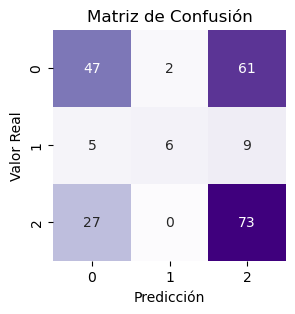


Resultados de validación cruzada para KNeighborsClassifier:
Exactitud: 0.5347826086956522
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.55      0.61      0.58       110
  Exponiendo       0.61      0.55      0.58        20
Respondiendo       0.50      0.45      0.47       100

    accuracy                           0.53       230
   macro avg       0.55      0.54      0.54       230
weighted avg       0.53      0.53      0.53       230



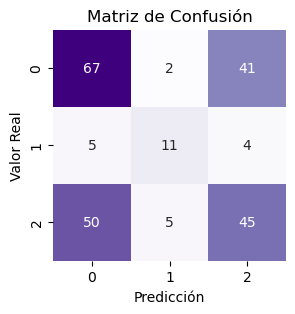

In [20]:
df_caracteristicas_hrv = df_caracteristicas_hrv.dropna()
predictions = cross_validation_classification_models(df_caracteristicas_hrv, 10)

**Observaciones:**
+ Si bien Random Forest presenta el mejor índice de "Accuracy" (0.60), este valor aún es cercano al que se obtendría por azar.

### <font color='purple'> **5.3 Evaluación con datos crudos** </font>

Observemos que resultados se obtienen con los datos crudos.

Resultados de validación cruzada para GaussianNB:
Exactitud: 0.47353324641460237
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.41      0.08      0.13      2620
  Exponiendo       0.57      0.50      0.53      2060
Respondiendo       0.45      0.80      0.57      2990

    accuracy                           0.47      7670
   macro avg       0.48      0.46      0.41      7670
weighted avg       0.47      0.47      0.41      7670



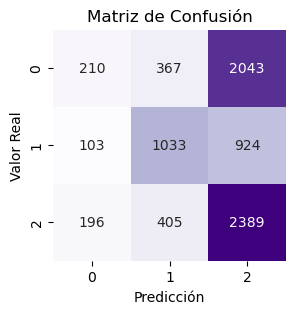


Resultados de validación cruzada para LogisticRegression:
Exactitud: 0.4541069100391134
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.00      0.00      0.00      2620
  Exponiendo       0.44      0.55      0.49      2060
Respondiendo       0.46      0.78      0.58      2990

    accuracy                           0.45      7670
   macro avg       0.30      0.45      0.36      7670
weighted avg       0.30      0.45      0.36      7670



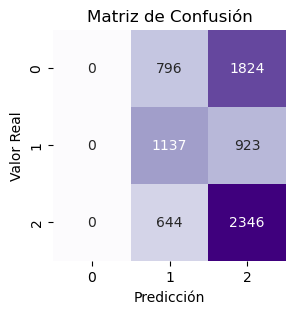


Resultados de validación cruzada para RandomForestClassifier:
Exactitud: 0.49282920469361147
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.44      0.39      0.41      2620
  Exponiendo       0.65      0.48      0.55      2060
Respondiendo       0.46      0.59      0.52      2990

    accuracy                           0.49      7670
   macro avg       0.52      0.49      0.49      7670
weighted avg       0.51      0.49      0.49      7670



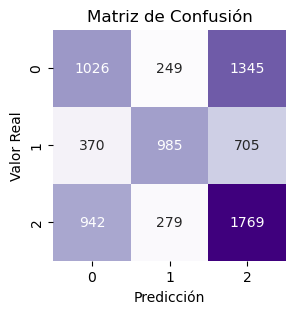


Resultados de validación cruzada para GradientBoostingClassifier:
Exactitud: 0.5168187744458931
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.48      0.35      0.41      2620
  Exponiendo       0.74      0.43      0.55      2060
Respondiendo       0.47      0.72      0.57      2990

    accuracy                           0.52      7670
   macro avg       0.56      0.50      0.51      7670
weighted avg       0.55      0.52      0.51      7670



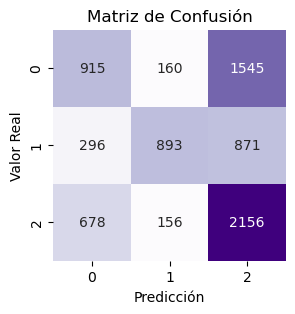


Resultados de validación cruzada para SVC:
Exactitud: 0.4483702737940026
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.00      0.00      0.00      2620
  Exponiendo       0.42      0.57      0.48      2060
Respondiendo       0.46      0.76      0.58      2990

    accuracy                           0.45      7670
   macro avg       0.29      0.44      0.35      7670
weighted avg       0.29      0.45      0.35      7670



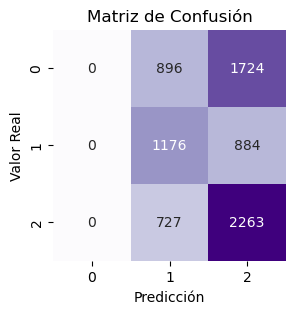


Resultados de validación cruzada para KNeighborsClassifier:
Exactitud: 0.45827900912646674
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.40      0.49      0.44      2620
  Exponiendo       0.55      0.51      0.53      2060
Respondiendo       0.46      0.39      0.42      2990

    accuracy                           0.46      7670
   macro avg       0.47      0.47      0.47      7670
weighted avg       0.46      0.46      0.46      7670



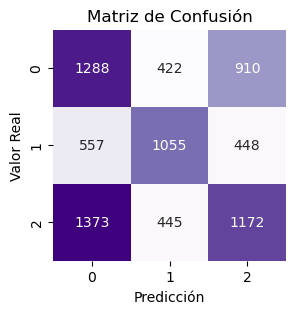

In [21]:
predictions = cross_validation_classification_models(datos_completos, 10)

**Observaciones:**
+ En concordancia con las expectativas, los valores crudos de la HRV no muestran un patrón discernible con respecto a los umbrales para la diferenciación entre contextos. Esta falta de patrón general dificulta la construcción de un modelo de clasificación eficiente, ya que la variabilidad interindividual es considerable.

+ En vista de lo anterior, se procederá a explorar la construcción de modelos personalizados para cada individuo. Esta estrategia busca identificar patrones específicos en la HRV de cada persona que permitan la diferenciación de contextos a nivel individual.

### <font color='purple'> **5.4 Modelos individuales** </font>

A continuación, se procederá a construir modelos para cada individuo utilizando los diferentes algoritmos de inferencia. Esta estrategia permitirá analizar las diferencias individuales en la respuesta al contexto. 

In [22]:
df_caracteristicas_hrv = df_caracteristicas_hrv.dropna()

#### <font color='purple'> **5.4.1 Andres** </font>

Resultados de validación cruzada para GaussianNB:
Exactitud: 0.375
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.44      0.60      0.51        20
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.27      0.15      0.19        20

    accuracy                           0.38        40
   macro avg       0.24      0.25      0.23        40
weighted avg       0.36      0.38      0.35        40



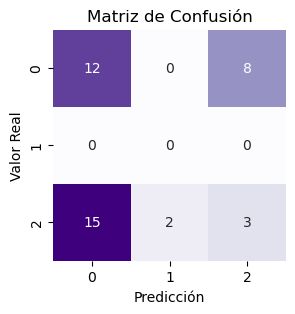


Resultados de validación cruzada para LogisticRegression:
Exactitud: 0.525
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.57      0.65      0.60        20
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.53      0.40      0.46        20

    accuracy                           0.53        40
   macro avg       0.37      0.35      0.35        40
weighted avg       0.55      0.53      0.53        40



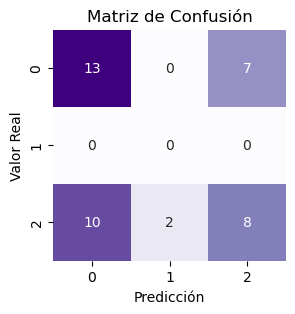


Resultados de validación cruzada para RandomForestClassifier:
Exactitud: 0.625
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.65      0.65      0.65        20
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.71      0.60      0.65        20

    accuracy                           0.62        40
   macro avg       0.45      0.42      0.43        40
weighted avg       0.68      0.62      0.65        40



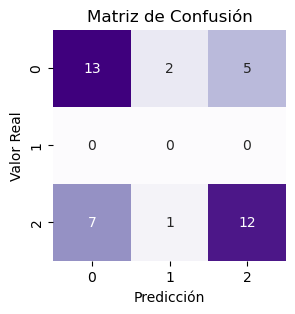


Resultados de validación cruzada para GradientBoostingClassifier:
Exactitud: 0.7
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.68      0.75      0.71        20
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.76      0.65      0.70        20

    accuracy                           0.70        40
   macro avg       0.48      0.47      0.47        40
weighted avg       0.72      0.70      0.71        40



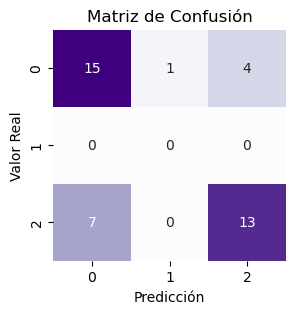


Resultados de validación cruzada para SVC:
Exactitud: 0.575
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.61      0.70      0.65        20
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.64      0.45      0.53        20

    accuracy                           0.57        40
   macro avg       0.42      0.38      0.39        40
weighted avg       0.63      0.57      0.59        40



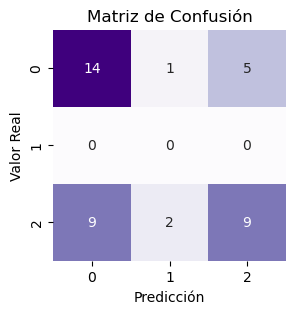


Resultados de validación cruzada para KNeighborsClassifier:
Exactitud: 0.65
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.71      0.75      0.73        20
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.73      0.55      0.63        20

    accuracy                           0.65        40
   macro avg       0.48      0.43      0.45        40
weighted avg       0.72      0.65      0.68        40



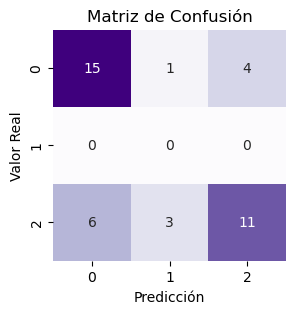

In [23]:
df_andres = df_caracteristicas_hrv.loc[df_caracteristicas_hrv['filename'] == 'ANDRES.txt']

predictions = cross_validation_classification_models(df_andres, 10)

#### <font color='purple'> **5.4.2 Ariana** </font>

Resultados de validación cruzada para GaussianNB:
Exactitud: 0.6
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.75      0.30      0.43        20
Respondiendo       0.56      0.90      0.69        20

    accuracy                           0.60        40
   macro avg       0.66      0.60      0.56        40
weighted avg       0.66      0.60      0.56        40



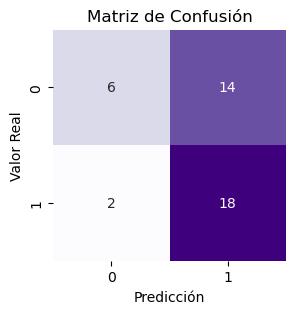


Resultados de validación cruzada para LogisticRegression:
Exactitud: 0.475
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.45      0.25      0.32        20
Respondiendo       0.48      0.70      0.57        20

    accuracy                           0.48        40
   macro avg       0.47      0.47      0.45        40
weighted avg       0.47      0.47      0.45        40



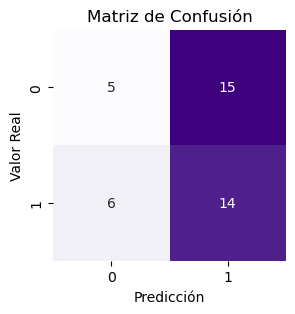


Resultados de validación cruzada para RandomForestClassifier:
Exactitud: 0.425
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.40      0.30      0.34        20
Respondiendo       0.44      0.55      0.49        20

    accuracy                           0.42        40
   macro avg       0.42      0.43      0.42        40
weighted avg       0.42      0.42      0.42        40



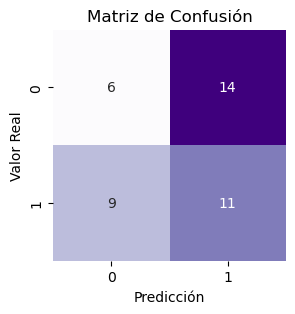


Resultados de validación cruzada para GradientBoostingClassifier:
Exactitud: 0.475
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.46      0.30      0.36        20
Respondiendo       0.48      0.65      0.55        20

    accuracy                           0.48        40
   macro avg       0.47      0.47      0.46        40
weighted avg       0.47      0.47      0.46        40



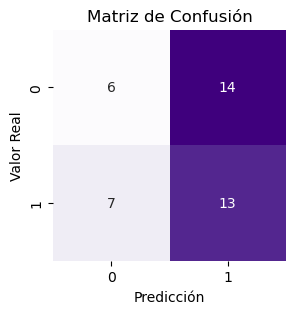


Resultados de validación cruzada para SVC:
Exactitud: 0.525
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.53      0.45      0.49        20
Respondiendo       0.52      0.60      0.56        20

    accuracy                           0.53        40
   macro avg       0.53      0.53      0.52        40
weighted avg       0.53      0.53      0.52        40



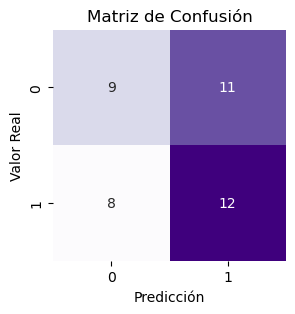


Resultados de validación cruzada para KNeighborsClassifier:
Exactitud: 0.575
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.60      0.45      0.51        20
Respondiendo       0.56      0.70      0.62        20

    accuracy                           0.57        40
   macro avg       0.58      0.57      0.57        40
weighted avg       0.58      0.57      0.57        40



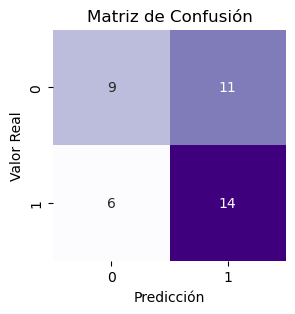

In [25]:
df_ariana = df_caracteristicas_hrv.loc[df_caracteristicas_hrv['filename'] == 'ARIANA.txt']

predictions = cross_validation_classification_models(df_ariana, 10)

#### <font color='purple'> **5.4.3 Dafne** </font>

Resultados de validación cruzada para GaussianNB:
Exactitud: 0.5
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.55      0.30      0.39        20
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.50      0.70      0.58        20

    accuracy                           0.50        40
   macro avg       0.35      0.33      0.32        40
weighted avg       0.52      0.50      0.49        40



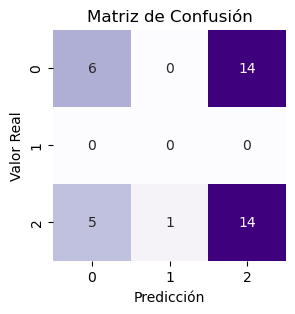


Resultados de validación cruzada para LogisticRegression:
Exactitud: 0.575
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.58      0.55      0.56        20
Respondiendo       0.57      0.60      0.59        20

    accuracy                           0.57        40
   macro avg       0.58      0.57      0.57        40
weighted avg       0.58      0.57      0.57        40



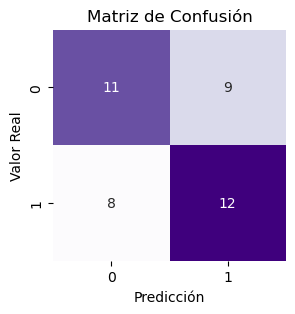


Resultados de validación cruzada para RandomForestClassifier:
Exactitud: 0.6
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.60      0.60      0.60        20
Respondiendo       0.60      0.60      0.60        20

    accuracy                           0.60        40
   macro avg       0.60      0.60      0.60        40
weighted avg       0.60      0.60      0.60        40



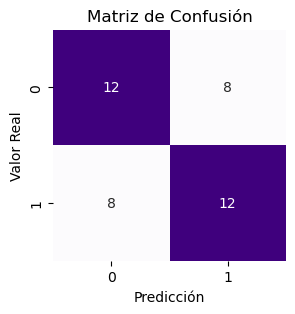


Resultados de validación cruzada para GradientBoostingClassifier:
Exactitud: 0.425
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.43      0.45      0.44        20
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.47      0.40      0.43        20

    accuracy                           0.42        40
   macro avg       0.30      0.28      0.29        40
weighted avg       0.45      0.42      0.44        40



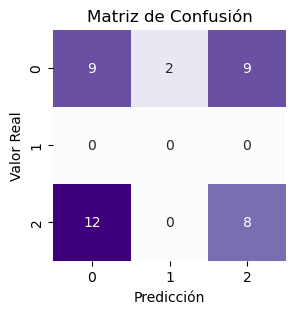


Resultados de validación cruzada para SVC:
Exactitud: 0.5
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.50      0.60      0.55        20
Respondiendo       0.50      0.40      0.44        20

    accuracy                           0.50        40
   macro avg       0.50      0.50      0.49        40
weighted avg       0.50      0.50      0.49        40



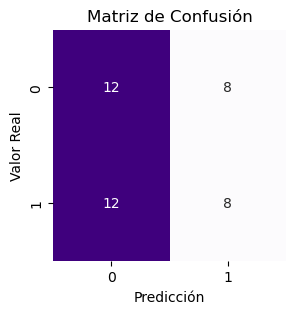


Resultados de validación cruzada para KNeighborsClassifier:
Exactitud: 0.5
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.50      0.60      0.55        20
Respondiendo       0.50      0.40      0.44        20

    accuracy                           0.50        40
   macro avg       0.50      0.50      0.49        40
weighted avg       0.50      0.50      0.49        40



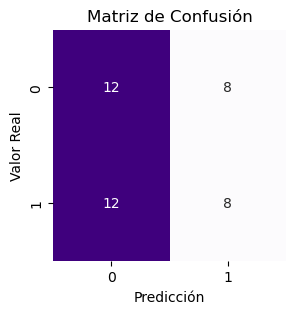

In [27]:
df_dafne = df_caracteristicas_hrv.loc[df_caracteristicas_hrv['filename'] == 'DAFNE.txt']

predictions = cross_validation_classification_models(df_dafne, 10)

#### <font color='purple'> **5.4.4 Jesus** </font>

Resultados de validación cruzada para GaussianNB:
Exactitud: 0.6
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.67      0.60      0.63        20
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.60      0.60      0.60        20

    accuracy                           0.60        40
   macro avg       0.42      0.40      0.41        40
weighted avg       0.63      0.60      0.62        40



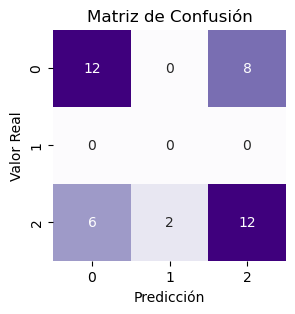


Resultados de validación cruzada para LogisticRegression:
Exactitud: 0.6
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.61      0.70      0.65        20
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.62      0.50      0.56        20

    accuracy                           0.60        40
   macro avg       0.41      0.40      0.40        40
weighted avg       0.62      0.60      0.60        40



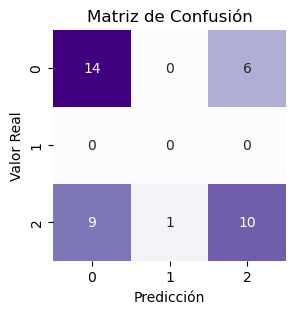


Resultados de validación cruzada para RandomForestClassifier:
Exactitud: 0.575
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.58      0.55      0.56        20
Respondiendo       0.57      0.60      0.59        20

    accuracy                           0.57        40
   macro avg       0.58      0.57      0.57        40
weighted avg       0.58      0.57      0.57        40



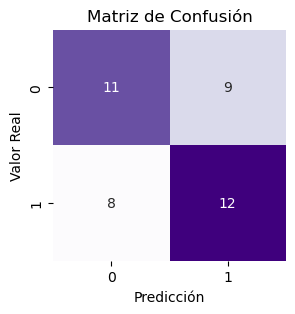


Resultados de validación cruzada para GradientBoostingClassifier:
Exactitud: 0.425
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.41      0.35      0.38        20
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.59      0.50      0.54        20

    accuracy                           0.42        40
   macro avg       0.33      0.28      0.31        40
weighted avg       0.50      0.42      0.46        40



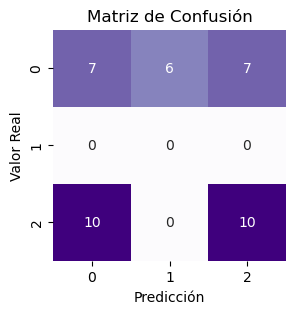


Resultados de validación cruzada para SVC:
Exactitud: 0.575
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.70      0.70      0.70        20
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.60      0.45      0.51        20

    accuracy                           0.57        40
   macro avg       0.43      0.38      0.40        40
weighted avg       0.65      0.57      0.61        40



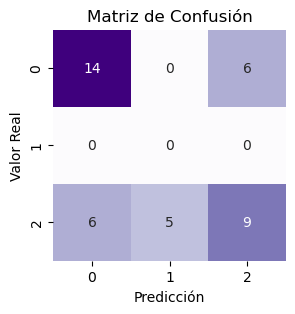


Resultados de validación cruzada para KNeighborsClassifier:
Exactitud: 0.475
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.48      0.55      0.51        20
Respondiendo       0.47      0.40      0.43        20

    accuracy                           0.48        40
   macro avg       0.47      0.48      0.47        40
weighted avg       0.47      0.47      0.47        40



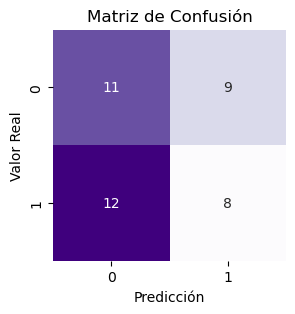

In [29]:
df_jesus = df_caracteristicas_hrv.loc[df_caracteristicas_hrv['filename'] == 'JESUS.txt']

predictions = cross_validation_classification_models(df_jesus, 10)

#### <font color='purple'> **5.4.5 Rachel** </font>

Resultados de validación cruzada para GaussianNB:
Exactitud: 0.6333333333333333
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.64      0.83      0.72        30
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.81      0.43      0.57        30

    accuracy                           0.63        60
   macro avg       0.48      0.42      0.43        60
weighted avg       0.73      0.63      0.64        60



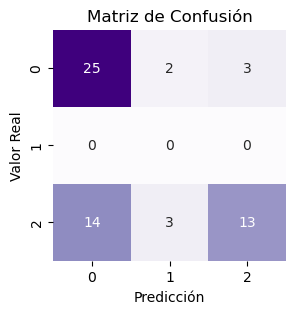


Resultados de validación cruzada para LogisticRegression:
Exactitud: 0.5166666666666667
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.51      0.63      0.57        30
Respondiendo       0.52      0.40      0.45        30

    accuracy                           0.52        60
   macro avg       0.52      0.52      0.51        60
weighted avg       0.52      0.52      0.51        60



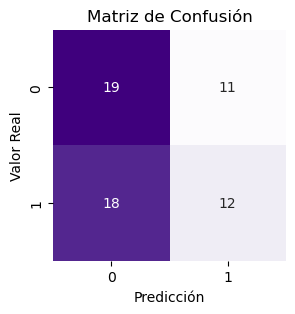


Resultados de validación cruzada para RandomForestClassifier:
Exactitud: 0.8
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.82      0.77      0.79        30
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.83      0.83      0.83        30

    accuracy                           0.80        60
   macro avg       0.55      0.53      0.54        60
weighted avg       0.83      0.80      0.81        60



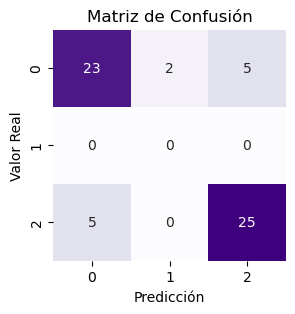


Resultados de validación cruzada para GradientBoostingClassifier:
Exactitud: 0.7
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.77      0.57      0.65        30
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.71      0.83      0.77        30

    accuracy                           0.70        60
   macro avg       0.50      0.47      0.47        60
weighted avg       0.74      0.70      0.71        60



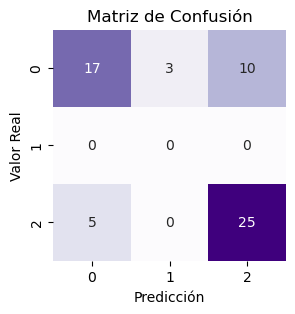


Resultados de validación cruzada para SVC:
Exactitud: 0.5833333333333334
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.56      0.73      0.64        30
Respondiendo       0.62      0.43      0.51        30

    accuracy                           0.58        60
   macro avg       0.59      0.58      0.57        60
weighted avg       0.59      0.58      0.57        60



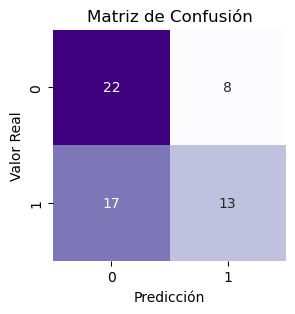


Resultados de validación cruzada para KNeighborsClassifier:
Exactitud: 0.5166666666666667
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.52      0.57      0.54        30
Respondiendo       0.52      0.47      0.49        30

    accuracy                           0.52        60
   macro avg       0.52      0.52      0.52        60
weighted avg       0.52      0.52      0.52        60



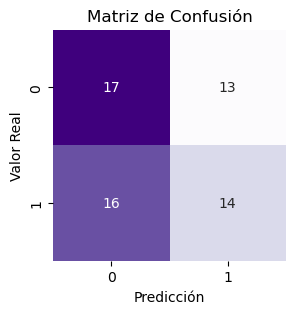

In [30]:
df_rachel = df_caracteristicas_hrv.loc[df_caracteristicas_hrv['filename'] == 'RACHEL.txt']

predictions = cross_validation_classification_models(df_rachel, 10)

#### <font color='purple'> **5.4.6 Scarlett** </font>

Resultados de validación cruzada para GaussianNB:
Exactitud: 0.6333333333333333
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       1.00      0.45      0.62        20
  Exponiendo       0.00      0.00      0.00         0
Respondiendo       0.56      1.00      0.71        10

    accuracy                           0.63        30
   macro avg       0.52      0.48      0.44        30
weighted avg       0.85      0.63      0.65        30



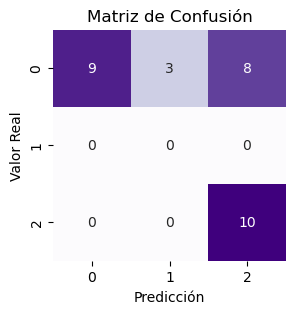


Resultados de validación cruzada para LogisticRegression:
Exactitud: 0.7666666666666667
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.88      0.75      0.81        20
Respondiendo       0.62      0.80      0.70        10

    accuracy                           0.77        30
   macro avg       0.75      0.78      0.75        30
weighted avg       0.79      0.77      0.77        30



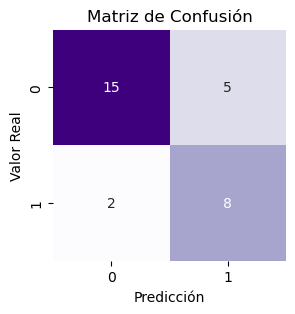


Resultados de validación cruzada para RandomForestClassifier:
Exactitud: 0.6
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.75      0.60      0.67        20
Respondiendo       0.43      0.60      0.50        10

    accuracy                           0.60        30
   macro avg       0.59      0.60      0.58        30
weighted avg       0.64      0.60      0.61        30



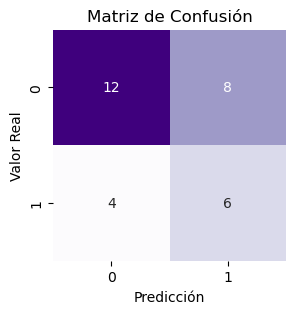


Resultados de validación cruzada para GradientBoostingClassifier:
Exactitud: 0.6666666666666666
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.78      0.70      0.74        20
Respondiendo       0.50      0.60      0.55        10

    accuracy                           0.67        30
   macro avg       0.64      0.65      0.64        30
weighted avg       0.69      0.67      0.67        30



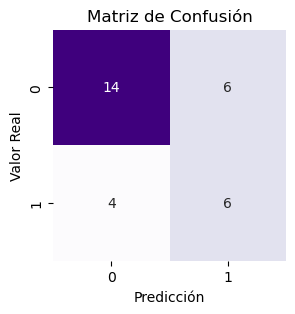


Resultados de validación cruzada para SVC:
Exactitud: 0.7666666666666667
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.93      0.70      0.80        20
Respondiendo       0.60      0.90      0.72        10

    accuracy                           0.77        30
   macro avg       0.77      0.80      0.76        30
weighted avg       0.82      0.77      0.77        30



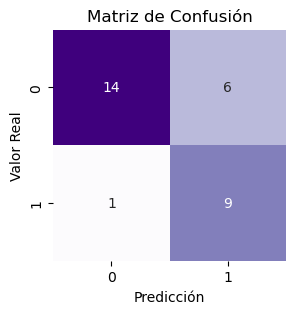


Resultados de validación cruzada para KNeighborsClassifier:
Exactitud: 0.6
Reporte de clasificación:
              precision    recall  f1-score   support

  Escuchando       0.79      0.55      0.65        20
Respondiendo       0.44      0.70      0.54        10

    accuracy                           0.60        30
   macro avg       0.61      0.62      0.59        30
weighted avg       0.67      0.60      0.61        30



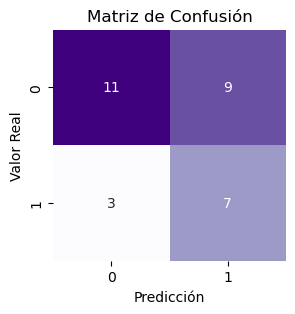

In [31]:
df_scarlett = df_caracteristicas_hrv.loc[df_caracteristicas_hrv['filename'] == 'SCARLETT.txt']

predictions = cross_validation_classification_models(df_scarlett, 10)

#### <font color='purple'> **5.4.7 Observaciones modelos individuales** </font>

Se presenta la exactitud individual del mejor modelo de clasificación para cada participante:

+ Andrés: GradientBoostingClassifier - Exactitud: 0.7
+ Ariana: GaussianNB - Exactitud: 0.6
+ Dafne: RandomForestClassifier - Exactitud: 0.6
+ Jesús: GaussianNB - Exactitud: 0.6
+ Rachel: RandomForestClassifier - Exactitud: 0.8
+ Scarlett: LogisticRegression - Exactitud: 0.77

Observamos que Rachel y Scarlett obtuvieron los mejores resultados, con una precisión de 0.8 y 0.77 respectivamente. Los modelos GaussianNB y RandomForestClassifier parecen ser los más adecuados para Ariana, Jesús y Dafne, mientras que GradientBoostingClassifier fue el mejor para Andrés. La elección del modelo óptimo varía según el participante, lo que resalta la importancia de la individualización en este tipo de análisis.

Debido a la escasez de datos y al enfoque exploratorio del estudio, se decidió no realizar una validación externa. La generación de modelos se consideró útil para el análisis, pero no para la aplicación práctica. La validación externa habría requerido dividir los datos disponibles en conjuntos de entrenamiento y validación, lo que habría reducido aún más el tamaño ya limitado de la muestra. Además, se consideró que la validación en sí no aportaría información significativa al análisis realizado en este notebook.

## <font color='purple'> **6.- Conclusiones** </font>

En este trabajo, se analizaron los datos fisiológicos de un grupo de participantes mientras exponían su anteproyecto ante dos profesores. Se capturó la variabilidad de la frecuencia cardíaca (HRV) mediante un sensor colocado en el esternón y se segmentaron los datos según el contexto de la exposición (exponiendo, escuchando a los profesores y respondiendo a los profesores).

Se construyeron modelos de clasificación para cada participante con el objetivo de distinguir entre los diferentes contextos. La exactitud de los modelos varió considerablemente entre participantes, lo que resalta la importancia de la individualización en el análisis de la HRV. Los mejores modelos para cada persona no fueron siempre los mismos, lo que sugiere que la respuesta individual a la variación del contexto es heterogénea.

Los modelos de clasificación basados en la HRV mostraron una exactitud considerable para algunos participantes, especialmente para Rachel (0.8 con el modelo Random Forest) y Scarlett (0.77 con el modelo de Regresión Logística). Los modelos GaussianNB y RandomForestClassifier fueron los más adecuados para Ariana, Jesús y Dafne, mientras que GradientBoostingClassifier fue el mejor para Andrés. La elección del modelo óptimo varió según el participante, lo que resalta la importancia de la individualización en este tipo de análisis.

Se necesitan futuras investigaciones para explorar estrategias que mejoren la generalización de los modelos de clasificación a diferentes contextos. Además, es importante considerar la individualidad en el análisis de la HRV para obtener resultados más exactos y confiables. Sería interesante observar si se obtienen mejores resultados utilizando electrocardiogramas (ECG) en lugar de solo la variabilidad de la frecuencia cardíaca (HRV). El ECG proporciona información más detallada sobre la actividad eléctrica del corazón, lo que podría permitir una clasificación más precisa de los diferentes contextos.